# Monthly data

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import the parquet library
import pyarrow.parquet as pq

## Features based on monthly returns (data)

### Handling monthly data - similar cleaning as with daily

In [2]:
# load FF3_month.csv, monthly.csv and monthly_features.parquet
df = pd.read_csv('monthly.csv')

c:\Users\tomta\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.head()

,PERMNO,date,SHRCD,DLRET,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,SPREAD
0,10000,1985-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-01-31,10.0,NaN,-2.50,-4.4375,-4.3750,1771.0,C,3680.0,0.250
2,10000,1986-02-28,10.0,NaN,-3.25,-4.3750,-3.2500,828.0,-0.257143,3680.0,0.250
3,10000,1986-03-31,10.0,NaN,-3.25,-4.4375,-4.4375,1078.0,0.365385,3680.0,0.125
4,10000,1986-04-30,10.0,NaN,-4.00,-4.3125,-4.0000,957.0,-0.098592,3793.0,0.250


In [4]:
print(df.shape)
df = df[df['SHRCD'].isin([10, 11])]
df = df.drop(columns = ['SHRCD'])
print(df.shape)

(4994317, 11)


(3824456, 10)


In [5]:
# count rows where RET is not a number
print(df['RET'].isna().sum())

# count rows where RET == C
print(df['RET'].value_counts()['C'])

43016
27922


In [6]:
df = df[df['RET'] != 'C']
df.shape

(3796534, 10)

In [7]:
df.dtypes

PERMNO      int64
date       object
DLRET      object
BIDLO     float64
ASKHI     float64
PRC       float64
VOL       float64
RET        object
SHROUT    float64
SPREAD    float64
dtype: object

In [8]:
# convert RET to numeric
df['RET'] = pd.to_numeric(df['RET'], errors='coerce')

In [9]:
# Convert 'RET' and 'DLRET' to numeric values, coercing errors into NaN
df['DLRET'] = pd.to_numeric(df['DLRET'], errors='coerce')

In [10]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [11]:
# count missing values in each column
df.isna().sum()

PERMNO          0
date            0
DLRET     3774434
BIDLO       77291
ASKHI       77291
PRC        102279
VOL        363687
RET        102279
SHROUT       3797
SPREAD    3086979
dtype: int64

In [12]:
# count how many time DLRET is -1
df['DLRET'].value_counts()[-1]

372

In [13]:
# replace -1 in 'DLRET' with nan
df['DLRET'] = df['DLRET'].replace(-1, np.nan)

In [14]:
# replace RET with DLRET where DLRET is not NA
df['RET'] = np.where(df['DLRET'].notna(), df['DLRET'], df['RET'])

# drop rows where RET is NA
df = df.dropna(subset=['RET'])

# drop the DLRET column
df = df.drop(columns=['DLRET'])


In [15]:
# count missing values in each column
df.isna().sum()

PERMNO          0
date            0
BIDLO           0
ASKHI           0
PRC         19100
VOL        284710
RET             0
SHROUT          0
SPREAD    3003800
dtype: int64

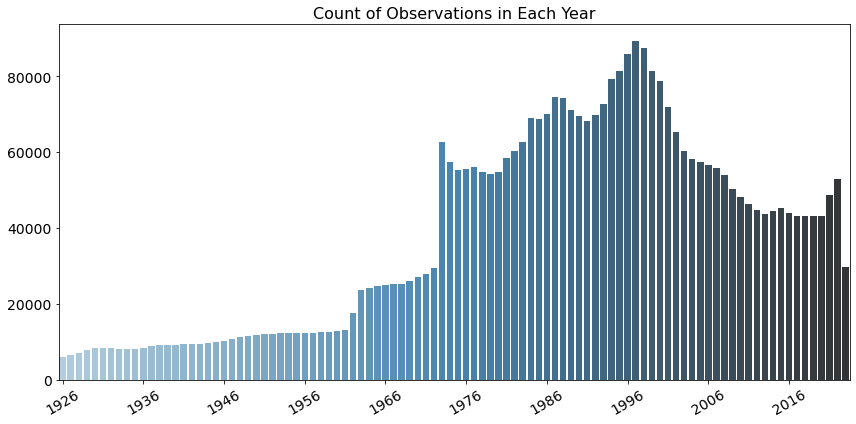

In [16]:
from tkinter import font
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
# Countplot for the number of observations each year
sns.countplot(x=df['date'].dt.year, palette='Blues_d')

# Title
plt.title('Count of Observations in Each Year', fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14)

# Modify x-axis to display only every tenth year
# Get the current x-ticks
xticks = plt.gca().get_xticks()
# Calculate which ticks to show
xticks_to_show = xticks[::10]

# Set the x-ticks to only show every tenth year
plt.gca().set_xticks(xticks_to_show)
# Set the labels for the new x-ticks
plt.gca().set_xticklabels(xticks_to_show.astype(int) +1926, rotation=30)
plt.yticks(fontsize=14)
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)

# Show plot with adjustments
plt.tight_layout()
plt.show()


### Market Cap (ME) and lagged market cap (LME)

In [17]:
# make PRC as absolute value of PRC - no negative prices
df['PRC'] = abs(df['PRC'])
df['BID'] = abs(df['BIDLO'])
df['ASK'] = abs(df['ASKHI'])

df.drop(columns = ['BIDLO', 'ASKHI', 'SPREAD'], inplace = True)


In [18]:
# create a new column MCAP = PRC * SHROUT

df['ME'] = df['PRC'] * df['SHROUT']

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.sort_values(['PERMNO', 'date'])

# create LME which is a lagged MCAP for each PERMNO
df['LME'] = df.groupby('PERMNO')['ME'].shift(1)

df.head()


,PERMNO,date,PRC,VOL,RET,SHROUT,BID,ASK,ME,LME
2,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,3.25000,4.37500,11960.00000,NaN
3,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,3.25000,4.43750,16330.00000,11960.00000
4,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,4.00000,4.31250,15172.00000,16330.00000
5,10000,1986-05-30,3.10938,1074.0,-0.222656,3793.0,3.06250,4.21875,11793.87834,15172.00000
6,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,2.90625,3.29688,11734.59375,11793.87834


In [19]:
df.head()

,PERMNO,date,PRC,VOL,RET,SHROUT,BID,ASK,ME,LME
2,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,3.25000,4.37500,11960.00000,NaN
3,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,3.25000,4.43750,16330.00000,11960.00000
4,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,4.00000,4.31250,15172.00000,16330.00000
5,10000,1986-05-30,3.10938,1074.0,-0.222656,3793.0,3.06250,4.21875,11793.87834,15172.00000
6,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,2.90625,3.29688,11734.59375,11793.87834


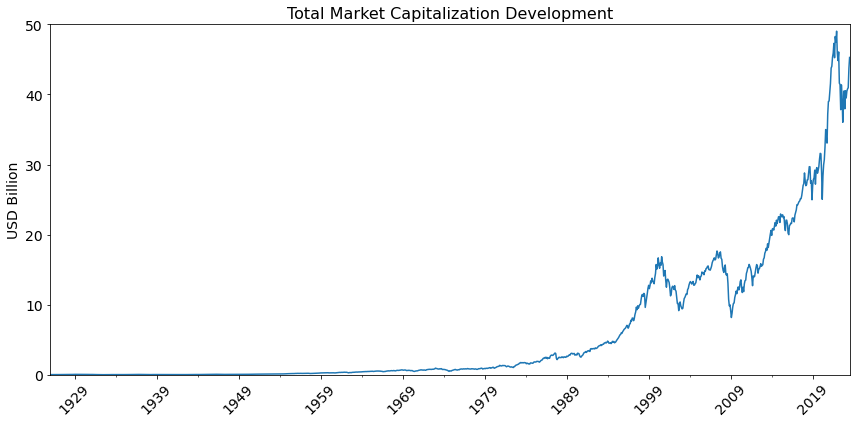

In [20]:
from tkinter import font
import matplotlib.pyplot as plt
import pandas as pd

# plot the sum of ME in each month
plt.figure(figsize=(12, 6))
monthly_sum = df.groupby(df['date'].dt.to_period('M'))['ME'].sum() / 1e9  # Convert to billions for y-axis scale

monthly_sum.plot()

# Set y-axis range from 0 to 50
plt.ylim(0, 50)

# Title and axis labels
plt.title('Total Market Capitalization Development', fontsize=16)
plt.ylabel('USD Billion', fontsize=14)
plt.xlabel('')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# make the lables font 14
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


# Show plot with adjustments
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


## Creating market variables from monthly data

### SPREAD = (ask-bid)/price


In [21]:
# SPREAD = (ASK - BID) / PRC
df['SPREAD'] = (df['ASK'] - df['BID']) / df['PRC']
df.head()

,PERMNO,date,PRC,VOL,RET,SHROUT,BID,ASK,ME,LME,SPREAD
2,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,3.25000,4.37500,11960.00000,NaN,0.346154
3,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,3.25000,4.43750,16330.00000,11960.00000,0.267606
4,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,4.00000,4.31250,15172.00000,16330.00000,0.078125
5,10000,1986-05-30,3.10938,1074.0,-0.222656,3793.0,3.06250,4.21875,11793.87834,15172.00000,0.371859
6,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,2.90625,3.29688,11734.59375,11793.87834,0.126264


In [22]:
# drop BID and ASK
df = df.drop(columns=['BID', 'ASK'])
df.head()

,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD
2,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,11960.00000,NaN,0.346154
3,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,16330.00000,11960.00000,0.267606
4,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,15172.00000,16330.00000,0.078125
5,10000,1986-05-30,3.10938,1074.0,-0.222656,3793.0,11793.87834,15172.00000,0.371859
6,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,11734.59375,11793.87834,0.126264


### LTURNOVER - lagged turnover (volume/shares outstanding)

In [23]:
# create a new variable RVOL = VOL/SHROUT
df['TURNOVER'] = df['VOL'] / df['SHROUT']

df.head()

# create LTURNOVER which is a lagged turnover of that sock in the previous month
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.sort_values(['PERMNO', 'date'])
df['LTURNOVER'] = df.groupby('PERMNO')['TURNOVER'].shift(1)

df.head()


,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER
2,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,11960.00000,NaN,0.346154,0.225000,NaN
3,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,16330.00000,11960.00000,0.267606,0.292935,0.225000
4,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,15172.00000,16330.00000,0.078125,0.252307,0.292935
5,10000,1986-05-30,3.10938,1074.0,-0.222656,3793.0,11793.87834,15172.00000,0.371859,0.283153,0.252307
6,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,11734.59375,11793.87834,0.126264,0.281835,0.283153


### Bull and bear runs (monthly)
Same code as for daily and weekly

In [24]:
# create a new column inc for the increase in price that takes the value 1 if the log return is positive, 0 otherwise
df['inc'] = (df['RET'] > 0).astype(int)

# create a new column dec for the decrease in price that takes the value 1 if the log return is negative, 0 otherwise
df['dec'] = (df['RET'] < 0).astype(int)

df.head(5)

,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER,inc,dec
2,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,11960.00000,NaN,0.346154,0.225000,NaN,0,1
3,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,16330.00000,11960.00000,0.267606,0.292935,0.225000,1,0
4,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,15172.00000,16330.00000,0.078125,0.252307,0.292935,0,1
5,10000,1986-05-30,3.10938,1074.0,-0.222656,3793.0,11793.87834,15172.00000,0.371859,0.283153,0.252307,0,1
6,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,11734.59375,11793.87834,0.126264,0.281835,0.283153,0,1


In [25]:
# Sort the DataFrame by 'PERMNO' and 'date'
df = df.sort_values(by=['PERMNO', 'date'])

# Identify when a trend changes or when it's a new stock
df['trend_change'] = (
    (df['inc'] != df['inc'].shift(1)) | 
    (df['dec'] != df['dec'].shift(1)) | 
    (df['PERMNO'] != df['PERMNO'].shift(1))
).astype(int)

# Create a segment identifier for consecutive trends
df['segment_id'] = df.groupby('PERMNO')['trend_change'].cumsum()

# Calculate lengths of bull and bear segments
df['bull_days'] = df.groupby(['PERMNO', 'segment_id'])['inc'].cumsum()
df['bear_days'] = df.groupby(['PERMNO', 'segment_id'])['dec'].cumsum()


# Reset 'bull_days' and 'bear_days' to 0 on days there's no increase or decrease
df.loc[df['inc'] == 0, 'bull_days'] = 0
df.loc[df['dec'] == 0, 'bear_days'] = 0


df['bull_days'] = df['bull_days'] - 1
df['bear_days'] = df['bear_days'] - 1

# if bull_days is negative, set it to 0
df.loc[df['bull_days'] < 0, 'bull_days'] = 0
df.loc[df['bear_days'] < 0, 'bear_days'] = 0

# if bear_days is > 12, set it to 12, same for bull_days
df.loc[df['bull_days'] > 12, 'bull_days'] = 12
df.loc[df['bear_days'] > 12, 'bear_days'] = 12

df.drop(['inc', 'dec', 'trend_change', 'segment_id'], axis = 1, inplace = True)

df.head(5)

,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER,bull_days,bear_days
2,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,11960.00000,NaN,0.346154,0.225000,NaN,0,0
3,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,16330.00000,11960.00000,0.267606,0.292935,0.225000,0,0
4,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,15172.00000,16330.00000,0.078125,0.252307,0.292935,0,0
5,10000,1986-05-30,3.10938,1074.0,-0.222656,3793.0,11793.87834,15172.00000,0.371859,0.283153,0.252307,0,1
6,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,11734.59375,11793.87834,0.126264,0.281835,0.283153,0,2


In [26]:
# rename bull_days and bear_days to bull_M and bear_M
df = df.rename(columns={'bull_days': 'bull_M', 'bear_days': 'bear_M'})
df.head(10)

,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER,bull_M,bear_M
2,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,11960.00000,NaN,0.346154,0.225000,NaN,0,0
3,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,16330.00000,11960.00000,0.267606,0.292935,0.225000,0,0
4,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,15172.00000,16330.00000,0.078125,0.252307,0.292935,0,0
5,10000,1986-05-30,3.10938,1074.0,-0.222656,3793.0,11793.87834,15172.00000,0.371859,0.283153,0.252307,0,1
6,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,11734.59375,11793.87834,0.126264,0.281835,0.283153,0,2
7,10000,1986-07-31,2.84375,1163.0,-0.080808,3793.0,10786.34375,11734.59375,0.296703,0.306617,0.281835,0,3
8,10000,1986-08-29,1.09375,3049.0,-0.615385,3793.0,4148.59375,10786.34375,1.457143,0.803849,0.306617,0,4
9,10000,1986-09-30,1.03125,3551.0,-0.057143,3793.0,3911.53125,4148.59375,0.303030,0.936198,0.803849,0,5
10,10000,1986-10-31,0.78125,1903.0,-0.242424,3843.0,3002.34375,3911.53125,0.360000,0.495186,0.936198,0,6
11,10000,1986-11-28,0.82813,2113.0,0.060000,3843.0,3182.50359,3002.34375,0.150942,0.549831,0.495186,0,0


### Create the target variable (return sign dummy)

In [27]:
# y = 1 if RET > 0, 0 otherwise
df['y'] = (df['RET'] > 0).astype(int)


In [28]:
# new column LRET = log(1 + RET)
df['LRET'] = np.log(1 + df['RET'])

df.head(5)

,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER,bull_M,bear_M,y,LRET
2,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,11960.00000,NaN,0.346154,0.225000,NaN,0,0,0,-0.297252
3,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,16330.00000,11960.00000,0.267606,0.292935,0.225000,0,0,1,0.311436
4,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,15172.00000,16330.00000,0.078125,0.252307,0.292935,0,0,0,-0.103797
5,10000,1986-05-30,3.10938,1074.0,-0.222656,3793.0,11793.87834,15172.00000,0.371859,0.283153,0.252307,0,1,0,-0.251872
6,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,11734.59375,11793.87834,0.126264,0.281835,0.283153,0,2,0,-0.005038


### STR - previous month return

In [29]:
# create a new column for the lagged RET called STR

df['STR'] = df.groupby('PERMNO')['RET'].shift(1)

df.head(5)


,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER,bull_M,bear_M,y,LRET,STR
2,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,11960.00000,NaN,0.346154,0.225000,NaN,0,0,0,-0.297252,NaN
3,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,16330.00000,11960.00000,0.267606,0.292935,0.225000,0,0,1,0.311436,-0.257143
4,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,15172.00000,16330.00000,0.078125,0.252307,0.292935,0,0,0,-0.103797,0.365385
5,10000,1986-05-30,3.10938,1074.0,-0.222656,3793.0,11793.87834,15172.00000,0.371859,0.283153,0.252307,0,1,0,-0.251872,-0.098592
6,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,11734.59375,11793.87834,0.126264,0.281835,0.283153,0,2,0,-0.005038,-0.222656


### LTR - cumulative return for months t-36 to t-13

In [30]:
# Assuming 'df' is your DataFrame
# Convert 'date' to datetime format and ensure it's sorted
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by=['PERMNO', 'date'], inplace=True)

# Create lagged LRET columns for t-1 to t-36
for lag in range(1, 37):
    df[f'LRET_lag{lag}'] = df.groupby('PERMNO')['LRET'].shift(lag)

# Calculate MOM, IMOM, and LTR

# LTR: cumulative return from month t-36 to t-13
df['LTR'] = df[[f'LRET_lag{lag}' for lag in range(13, 37)]].sum(axis=1)


### IMOM = cumulative return from t-12 to t-7

In [31]:

# IMOM: cumulative return from month t-12 to t-7
df['IMOM'] = df[[f'LRET_lag{lag}' for lag in range(7, 13)]].sum(axis=1)

### MOM = cumulative return from month t-12 to t-2

In [32]:
# MOM: cumulative return from month t-12 to t-2
df['MOM'] = df[[f'LRET_lag{lag}' for lag in range(2, 13)]].sum(axis=1)

# Optional: Drop the intermediate lagged columns if they are no longer needed
df.drop(columns=[f'LRET_lag{lag}' for lag in range(1, 37)], inplace=True)

df.tail(5)

,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER,bull_M,bear_M,y,LRET,STR,LTR,IMOM,MOM
4994312,93436,2023-03-31,207.46001,33115078.0,0.008507,3169314.0,6.575059e+08,6.508877e+08,0.166490,10.448658,11.453383,2,0,1,0.008471,0.187565,1.874152,-0.051388,-0.515812
4994313,93436,2023-04-28,164.31000,25038244.0,-0.207992,3169504.0,5.207812e+08,6.575059e+08,0.249650,7.899736,10.448658,0,0,0,-0.233184,0.008507,2.330438,-0.303206,-0.557411
4994314,93436,2023-05-31,203.92999,26816033.0,0.241130,3169504.0,6.463569e+08,5.207812e+08,0.213897,8.460640,7.899736,0,0,1,0.216022,-0.207992,1.717103,-0.243428,-0.335815
4994315,93436,2023-06-30,261.76999,34409322.0,0.283627,3174000.0,8.308579e+08,6.463569e+08,0.255683,10.840996,8.460640,1,0,1,0.249690,0.241130,1.513033,-0.260955,-0.430659
4994316,93436,2023-07-31,267.42999,23934292.0,0.021622,3173994.0,8.488212e+08,8.308579e+08,0.140710,7.540749,10.840996,2,0,1,0.021392,0.283627,1.137267,-0.600110,-0.095979


In [33]:
# replace 0 in MOM, IMOM, LTR with nan
df['MOM'] = df['MOM'].replace(0, np.nan)
df['IMOM'] = df['IMOM'].replace(0, np.nan)
df['LTR'] = df['LTR'].replace(0, np.nan)


In [34]:
df.head(5)

,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER,bull_M,bear_M,y,LRET,STR,LTR,IMOM,MOM
2,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,11960.00000,NaN,0.346154,0.225000,NaN,0,0,0,-0.297252,NaN,NaN,NaN,NaN
3,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,16330.00000,11960.00000,0.267606,0.292935,0.225000,0,0,1,0.311436,-0.257143,NaN,NaN,NaN
4,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,15172.00000,16330.00000,0.078125,0.252307,0.292935,0,0,0,-0.103797,0.365385,NaN,NaN,-0.297252
5,10000,1986-05-30,3.10938,1074.0,-0.222656,3793.0,11793.87834,15172.00000,0.371859,0.283153,0.252307,0,1,0,-0.251872,-0.098592,NaN,NaN,0.014185
6,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,11734.59375,11793.87834,0.126264,0.281835,0.283153,0,2,0,-0.005038,-0.222656,NaN,NaN,-0.089613


### PCTHIGH
is the ratio of stock price at the end of the previous calendar month and the previous 52 week (I use monthly data for simplicity) high price

In [35]:

# Calculate the rolling 12-month high for each stock
# Since the data is monthly, 12 months correspond to the 52-week high
df['12M_high'] = df.groupby('PERMNO')['PRC'].transform(lambda x: x.rolling(window=12, min_periods=1).max())

# Calculate PCTHIGH as the ratio of the current month's price to the 12-month high
df['PCTHIGH'] = df['PRC'] / df['12M_high']

# Shift the PCTHIGH column by 1 to represent the end of the previous month's ratio to the 12-month high
df['PCTHIGH_lag1'] = df.groupby('PERMNO')['PCTHIGH'].shift(1)

# Cleanup: Drop intermediate columns if they are no longer needed
df.drop(columns=['12M_high', 'PCTHIGH'], inplace=True)

# rename PCTHIGH_lag1 to PCTHIGH
df = df.rename(columns={'PCTHIGH_lag1': 'PCTHIGH'})

# Display the DataFrame to verify the results
df.tail()


,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER,bull_M,bear_M,y,LRET,STR,LTR,IMOM,MOM,PCTHIGH
4994312,93436,2023-03-31,207.46001,33115078.0,0.008507,3169314.0,6.575059e+08,6.508877e+08,0.166490,10.448658,11.453383,2,0,1,0.008471,0.187565,1.874152,-0.051388,-0.515812,0.190896
4994313,93436,2023-04-28,164.31000,25038244.0,-0.207992,3169504.0,5.207812e+08,6.575059e+08,0.249650,7.899736,10.448658,0,0,0,-0.233184,0.008507,2.330438,-0.303206,-0.557411,0.232722
4994314,93436,2023-05-31,203.92999,26816033.0,0.241130,3169504.0,6.463569e+08,5.207812e+08,0.213897,8.460640,7.899736,0,0,1,0.216022,-0.207992,1.717103,-0.243428,-0.335815,0.184318
4994315,93436,2023-06-30,261.76999,34409322.0,0.283627,3174000.0,8.308579e+08,6.463569e+08,0.255683,10.840996,8.460640,1,0,1,0.249690,0.241130,1.513033,-0.260955,-0.430659,0.228762
4994316,93436,2023-07-31,267.42999,23934292.0,0.021622,3173994.0,8.488212e+08,8.308579e+08,0.140710,7.540749,10.840996,2,0,1,0.021392,0.283627,1.137267,-0.600110,-0.095979,0.293645


In [36]:
# ensure the date is the same for all stocks (last day of the month)

df['date'] = df['date'] + pd.offsets.MonthEnd(0)


In [37]:
df.head(5)

,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER,bull_M,bear_M,y,LRET,STR,LTR,IMOM,MOM,PCTHIGH
2,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,11960.00000,NaN,0.346154,0.225000,NaN,0,0,0,-0.297252,NaN,NaN,NaN,NaN,NaN
3,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,16330.00000,11960.00000,0.267606,0.292935,0.225000,0,0,1,0.311436,-0.257143,NaN,NaN,NaN,1.000000
4,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,15172.00000,16330.00000,0.078125,0.252307,0.292935,0,0,0,-0.103797,0.365385,NaN,NaN,-0.297252,1.000000
5,10000,1986-05-31,3.10938,1074.0,-0.222656,3793.0,11793.87834,15172.00000,0.371859,0.283153,0.252307,0,1,0,-0.251872,-0.098592,NaN,NaN,0.014185,0.901408
6,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,11734.59375,11793.87834,0.126264,0.281835,0.283153,0,2,0,-0.005038,-0.222656,NaN,NaN,-0.089613,0.700705


## Merging with features from daily returns

In [38]:
features = pd.read_parquet('monthly_features.parquet')
features.head()

,PERMNO,date,bull_D,bear_D,bull_W,bear_W,sVarM,mVarM,sVarM_lag1,sVarM_lag2,sVarM_lag3,mVarM_lag1,mVarM_lag2,mVarM_lag3
0,10000,1986-01-31,0,0,1,0,0.004058,0.000068,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-02-28,0,0,0,1,0.000973,0.000031,0.004058,NaN,NaN,0.000068,NaN,NaN
2,10000,1986-03-31,0,0,0,0,0.001993,0.000040,0.000973,0.004058,NaN,0.000031,0.000068,NaN
3,10000,1986-04-30,0,1,0,0,0.000163,0.000089,0.001993,0.000973,0.004058,0.000040,0.000031,0.000068
4,10000,1986-05-31,0,0,0,0,0.001569,0.000044,0.000163,0.001993,0.000973,0.000089,0.000040,0.000031


In [39]:
# ensure the date is the same for all stocks (last day of the month)
features['date'] = features['date'] + pd.offsets.MonthEnd(0)

In [40]:
# get the minimum and maximum date in the features DataFrame
print(features['date'].min())
print(features['date'].max())


1926-07-31 00:00:00
2022-07-31 00:00:00


In [41]:
# drop sVarM and mVarM - we will use the lagged values instead
features = features.drop(columns=['sVarM', 'mVarM'])

# rename sVarM_lag1 to IVOL, sVarM_lag2 to IVOL2, mVarM_lag1 to MVOL, mVarM_lag2 to MVOL2, sVarM_lag3 to IVOL3, mVarM_lag3 to MVOL3

features = features.rename(columns={'sVarM_lag1': 'IVOL', 'sVarM_lag2': 'IVOL2', 
                                    'mVarM_lag1': 'MVOL', 'mVarM_lag2': 'MVOL2', 
                                    'sVarM_lag3': 'IVOL3', 'mVarM_lag3': 'MVOL3'})

features.head()

,PERMNO,date,bull_D,bear_D,bull_W,bear_W,IVOL,IVOL2,IVOL3,MVOL,MVOL2,MVOL3
0,10000,1986-01-31,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-02-28,0,0,0,1,0.004058,NaN,NaN,0.000068,NaN,NaN
2,10000,1986-03-31,0,0,0,0,0.000973,0.004058,NaN,0.000031,0.000068,NaN
3,10000,1986-04-30,0,1,0,0,0.001993,0.000973,0.004058,0.000040,0.000031,0.000068
4,10000,1986-05-31,0,0,0,0,0.000163,0.001993,0.000973,0.000089,0.000040,0.000031


In [42]:
# merge df and features
df = df.merge(features, on=['PERMNO', 'date'], how='left')

df.head()

,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER,bull_M,bear_M,y,LRET,STR,LTR,IMOM,MOM,PCTHIGH,bull_D,bear_D,bull_W,bear_W,IVOL,IVOL2,IVOL3,MVOL,MVOL2,MVOL3
0,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,11960.00000,NaN,0.346154,0.225000,NaN,0,0,0,-0.297252,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.004058,NaN,NaN,0.000068,NaN,NaN
1,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,16330.00000,11960.00000,0.267606,0.292935,0.225000,0,0,1,0.311436,-0.257143,NaN,NaN,NaN,1.000000,0.0,0.0,0.0,0.0,0.000973,0.004058,NaN,0.000031,0.000068,NaN
2,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,15172.00000,16330.00000,0.078125,0.252307,0.292935,0,0,0,-0.103797,0.365385,NaN,NaN,-0.297252,1.000000,0.0,1.0,0.0,0.0,0.001993,0.000973,0.004058,0.000040,0.000031,0.000068
3,10000,1986-05-31,3.10938,1074.0,-0.222656,3793.0,11793.87834,15172.00000,0.371859,0.283153,0.252307,0,1,0,-0.251872,-0.098592,NaN,NaN,0.014185,0.901408,0.0,0.0,0.0,0.0,0.000163,0.001993,0.000973,0.000089,0.000040,0.000031
4,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,11734.59375,11793.87834,0.126264,0.281835,0.283153,0,2,0,-0.005038,-0.222656,NaN,NaN,-0.089613,0.700705,0.0,0.0,0.0,0.0,0.001569,0.000163,0.001993,0.000044,0.000089,0.000040


## Merging with market data

### Correct format of FF data

In [43]:
ff3 = pd.read_csv('FF3_month.csv', header = 2, parse_dates = True)
ff3 = ff3[:-1]
ff3 = ff3.rename(columns = {'Unnamed: 0': 'date'})

ff3.head()


,date,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.56,-2.43,0.22
1,192608,2.64,-1.17,3.82,0.25
2,192609,0.36,-1.40,0.13,0.23
3,192610,-3.24,-0.09,0.70,0.32
4,192611,2.53,-0.10,-0.51,0.31


In [44]:
ff3.tail()

,date,Mkt-RF,SMB,HML,RF
1264,2019,28.28,-6.14,-10.46,2.15
1265,2020,23.66,13.18,-46.67,0.45
1266,2021,23.56,-3.89,25.49,0.04
1267,2022,-21.60,-6.95,25.81,1.43
1268,2023,21.68,-3.22,-13.57,4.95


In [45]:
# check the data on index 1170 to 1180
ff3[1165:1175]


,date,Mkt-RF,SMB,HML,RF
1165,202308,-2.39,-3.16,-1.06,0.45
1166,202309,-5.24,-2.51,1.52,0.43
1167,202310,-3.19,-3.87,0.19,0.47
1168,202311,8.84,-0.02,1.64,0.44
1169,202312,4.85,6.35,4.94,0.43
1170,Annual Factors: January-December,NaN,NaN,NaN,NaN
1171,NaN,Mkt-RF,SMB,HML,RF
1172,1927,29.47,-2.04,-4.54,3.12
1173,1928,35.39,4.51,-6.17,3.56
1174,1929,-19.54,-30.70,11.67,4.75


In [46]:
# drop rows with row index 1170 and higher
ff3 = ff3.drop(ff3.index[1170:])
ff3.tail()

,date,Mkt-RF,SMB,HML,RF
1165,202308,-2.39,-3.16,-1.06,0.45
1166,202309,-5.24,-2.51,1.52,0.43
1167,202310,-3.19,-3.87,0.19,0.47
1168,202311,8.84,-0.02,1.64,0.44
1169,202312,4.85,6.35,4.94,0.43


In [47]:
# Assuming ff3 is your DataFrame for the ff3 dataset
# Convert the 'date' column to string to ensure proper formatting
ff3['date'] = ff3['date'].astype(str)

# Now, convert 'date' to datetime format, assuming the first day of the month, then adjust to the month's end
ff3['date'] = pd.to_datetime(ff3['date'] + '01', format='%Y%m%d') + pd.offsets.MonthEnd(1)

# Check the transformation
print(ff3.head())

        date    Mkt-RF       SMB       HML        RF
0 1926-07-31      2.96     -2.56     -2.43      0.22
1 1926-08-31      2.64     -1.17      3.82      0.25
2 1926-09-30      0.36     -1.40      0.13      0.23
3 1926-10-31     -3.24     -0.09      0.70      0.32
4 1926-11-30      2.53     -0.10     -0.51      0.31


In [48]:
# save the ff3 DataFrame to a csv file
ff3.to_csv('FF3_clean.csv', index=False)

In [49]:
# drop SMB and HML columns

ff3 = ff3.drop(['SMB', 'HML'], axis = 1)
ff3.head()

,date,Mkt-RF,RF
0,1926-07-31,2.96,0.22
1,1926-08-31,2.64,0.25
2,1926-09-30,0.36,0.23
3,1926-10-31,-3.24,0.32
4,1926-11-30,2.53,0.31


In [50]:
# translate all colmns in ff3 (except date) to a numeric format

ff3.iloc[:, 1:] = ff3.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# divide the values in the 'Mkt-RF' and RF column by 100
ff3['Mkt-RF'] = ff3['Mkt-RF'] / 100
ff3['RF'] = ff3['RF'] / 100

# check the transformation
ff3.head()

,date,Mkt-RF,RF
0,1926-07-31,0.0296,0.0022
1,1926-08-31,0.0264,0.0025
2,1926-09-30,0.0036,0.0023
3,1926-10-31,-0.0324,0.0032
4,1926-11-30,0.0253,0.0031


In [51]:
# create a "Mkt" column in ff3 that is the sum of "Mkt-RF" and "RF"
ff3['Mkt'] = ff3['Mkt-RF'] + ff3['RF']

ff3.head()

,date,Mkt-RF,RF,Mkt
0,1926-07-31,0.0296,0.0022,0.0318
1,1926-08-31,0.0264,0.0025,0.0289
2,1926-09-30,0.0036,0.0023,0.0059
3,1926-10-31,-0.0324,0.0032,-0.0292
4,1926-11-30,0.0253,0.0031,0.0284


In [52]:
# create a logMkt column in ff3 that is the log of "1+Mkt"

ff3['logMkt'] = np.log(1 + ff3['Mkt'])

ff3.head()


,date,Mkt-RF,RF,Mkt,logMkt
0,1926-07-31,0.0296,0.0022,0.0318,0.031305
1,1926-08-31,0.0264,0.0025,0.0289,0.028490
2,1926-09-30,0.0036,0.0023,0.0059,0.005883
3,1926-10-31,-0.0324,0.0032,-0.0292,-0.029635
4,1926-11-30,0.0253,0.0031,0.0284,0.028004


### Lagged market return (LMKT)

In [53]:
# create a new column for the lagged Mkt called LMKT

ff3['LMKT'] = ff3['Mkt'].shift(1)
ff3['LMKT2'] = ff3['Mkt'].shift(2)
ff3['LMKT3'] = ff3['Mkt'].shift(3)

ff3.head()

,date,Mkt-RF,RF,Mkt,logMkt,LMKT,LMKT2,LMKT3
0,1926-07-31,0.0296,0.0022,0.0318,0.031305,NaN,NaN,NaN
1,1926-08-31,0.0264,0.0025,0.0289,0.028490,0.0318,NaN,NaN
2,1926-09-30,0.0036,0.0023,0.0059,0.005883,0.0289,0.0318,NaN
3,1926-10-31,-0.0324,0.0032,-0.0292,-0.029635,0.0059,0.0289,0.0318
4,1926-11-30,0.0253,0.0031,0.0284,0.028004,-0.0292,0.0059,0.0289


### LTR, MOM and IMOM but for market returns

In [54]:
# Assuming 'ff3' is your DataFrame
# Ensure 'date' is in datetime format
ff3['date'] = pd.to_datetime(ff3['date'])

# Calculate lagged market log returns for t-1 to t-36 to cover all necessary periods
for lag in range(1, 37):
    ff3[f'MlogRet_lag{lag}'] = ff3['logMkt'].shift(lag)

# Calculate MMOM (market momentum) as the cumulative return from month t-12 to t-2
ff3['MMOM'] = ff3[[f'MlogRet_lag{lag}' for lag in range(2, 13)]].sum(axis=1)

# Calculate MIMOM (intermediate market momentum) as the cumulative return from month t-12 to t-7
ff3['MIMOM'] = ff3[[f'MlogRet_lag{lag}' for lag in range(7, 13)]].sum(axis=1)

# Calculate MLTR (long-term market return) as the cumulative return from month t-36 to t-13
ff3['MLTR'] = ff3[[f'MlogRet_lag{lag}' for lag in range(13, 37)]].sum(axis=1)

# Cleanup: Drop the intermediate lagged return columns if they are no longer needed
ff3.drop(columns=[f'MlogRet_lag{lag}' for lag in range(1, 37)], inplace=True)

ff3.tail()

,date,Mkt-RF,RF,Mkt,logMkt,LMKT,LMKT2,LMKT3,MMOM,MIMOM,MLTR
1165,2023-08-31,-0.0239,0.0045,-0.0194,-0.019591,0.0366,0.0686,0.0071,0.086283,-0.002337,0.235077
1166,2023-09-30,-0.0524,0.0043,-0.0481,-0.049295,-0.0194,0.0366,0.0686,0.158686,0.011465,0.124998
1167,2023-10-31,-0.0319,0.0047,-0.0272,-0.027577,-0.0481,-0.0194,0.0366,0.235165,0.135831,0.065799
1168,2023-11-30,0.0884,0.0044,0.0928,0.088743,-0.0272,-0.0481,-0.0194,0.108354,0.067869,0.164437
1169,2023-12-31,0.0485,0.0043,0.0528,0.051453,0.0928,-0.0272,-0.0481,0.033035,0.027202,0.094574


In [55]:
# drop Mkt-RF, RF, Mkt and logMkt columns and save as market_features

market_features = ff3.drop(['Mkt-RF', 'RF', 'Mkt', 'logMkt'], axis = 1)
market_features.head()

,date,LMKT,LMKT2,LMKT3,MMOM,MIMOM,MLTR
0,1926-07-31,NaN,NaN,NaN,0.000000,0.0,0.0
1,1926-08-31,0.0318,NaN,NaN,0.000000,0.0,0.0
2,1926-09-30,0.0289,0.0318,NaN,0.031305,0.0,0.0
3,1926-10-31,0.0059,0.0289,0.0318,0.059795,0.0,0.0
4,1926-11-30,-0.0292,0.0059,0.0289,0.065678,0.0,0.0


In [56]:
# replace 0 in market_features with nan

market_features = market_features.replace(0, np.nan)

# should not be problematic - we will not make predictions for first few years of the data

market_features.head()

,date,LMKT,LMKT2,LMKT3,MMOM,MIMOM,MLTR
0,1926-07-31,NaN,NaN,NaN,NaN,NaN,NaN
1,1926-08-31,0.0318,NaN,NaN,NaN,NaN,NaN
2,1926-09-30,0.0289,0.0318,NaN,0.031305,NaN,NaN
3,1926-10-31,0.0059,0.0289,0.0318,0.059795,NaN,NaN
4,1926-11-30,-0.0292,0.0059,0.0289,0.065678,NaN,NaN


In [57]:
# merge market_features to df

df = df.merge(market_features, on='date', how='left')

df.sort_values(['PERMNO', 'date'], inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER,bull_M,bear_M,y,LRET,STR,LTR,IMOM,MOM,PCTHIGH,bull_D,bear_D,bull_W,bear_W,IVOL,IVOL2,IVOL3,MVOL,MVOL2,MVOL3,LMKT,LMKT2,LMKT3,MMOM,MIMOM,MLTR
0,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,11960.00000,NaN,0.346154,0.225000,NaN,0,0,0,-0.297252,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.004058,NaN,NaN,0.000068,NaN,NaN,0.0121,0.0453,0.0709,0.199515,0.085978,0.281355
1,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,16330.00000,11960.00000,0.267606,0.292935,0.225000,0,0,1,0.311436,-0.257143,NaN,NaN,NaN,1.000000,0.0,0.0,0.0,0.0,0.000973,0.004058,NaN,0.000031,0.000068,NaN,0.0766,0.0121,0.0453,0.193703,0.063427,0.267599
2,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,15172.00000,16330.00000,0.078125,0.252307,0.292935,0,0,0,-0.103797,0.365385,NaN,NaN,-0.297252,1.000000,0.0,1.0,0.0,0.0,0.001993,0.000973,0.004058,0.000040,0.000031,0.000068,0.0548,0.0766,0.0121,0.269713,0.025432,0.231479
3,10000,1986-05-31,3.10938,1074.0,-0.222656,3793.0,11793.87834,15172.00000,0.371859,0.283153,0.252307,0,1,0,-0.251872,-0.098592,NaN,NaN,0.014185,0.901408,0.0,0.0,0.0,0.0,0.000163,0.001993,0.000973,0.000089,0.000040,0.000031,-0.0079,0.0548,0.0766,0.325467,0.073477,0.157872
4,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,11734.59375,11793.87834,0.126264,0.281835,0.283153,0,2,0,-0.005038,-0.222656,NaN,NaN,-0.089613,0.700705,0.0,0.0,0.0,0.0,0.001569,0.000163,0.001993,0.000044,0.000089,0.000040,0.0511,-0.0079,0.0548,0.261628,0.086069,0.201752


In [58]:
df.columns

Index(['PERMNO', 'date', 'PRC', 'VOL', 'RET', 'SHROUT', 'ME', 'LME', 'SPREAD',
       'TURNOVER', 'LTURNOVER', 'bull_M', 'bear_M', 'y', 'LRET', 'STR', 'LTR',
       'IMOM', 'MOM', 'PCTHIGH', 'bull_D', 'bear_D', 'bull_W', 'bear_W',
       'IVOL', 'IVOL2', 'IVOL3', 'MVOL', 'MVOL2', 'MVOL3', 'LMKT', 'LMKT2',
       'LMKT3', 'MMOM', 'MIMOM', 'MLTR'],
      dtype='object')

In [59]:
df.isna().sum()

PERMNO            0
date              0
PRC           19100
VOL          284710
RET               0
SHROUT            0
ME            19100
LME           26529
SPREAD        19100
TURNOVER     284710
LTURNOVER    309384
bull_M            0
bear_M            0
y                 0
LRET              0
STR           26529
LTR          340224
IMOM         188193
MOM           55407
PCTHIGH       26529
bull_D        62277
bear_D        62277
bull_W        62277
bear_W        62277
IVOL          66854
IVOL2         92050
IVOL3        117201
MVOL          66492
MVOL2         91603
MVOL3        116750
LMKT           4560
LMKT2          5083
LMKT3          5600
MMOM           4031
MIMOM          6643
MLTR           9869
dtype: int64

## Create the BASE dataset - select features
All the BASE variables are lagged already

#### Select what to keep for the sign prediciton

In [60]:
basic = df[['PERMNO', 'date', 'RET', 'ME', 'bull_D', 'bear_D', 'bull_W', 'bear_W', 'bull_M', 'bear_M', 'LMKT', 'IVOL',  'y' ]].copy()
basic.head()

,PERMNO,date,RET,ME,bull_D,bear_D,bull_W,bear_W,bull_M,bear_M,LMKT,IVOL,y
0,10000,1986-02-28,-0.257143,11960.00000,0.0,0.0,0.0,1.0,0,0,0.0121,0.004058,0
1,10000,1986-03-31,0.365385,16330.00000,0.0,0.0,0.0,0.0,0,0,0.0766,0.000973,1
2,10000,1986-04-30,-0.098592,15172.00000,0.0,1.0,0.0,0.0,0,0,0.0548,0.001993,0
3,10000,1986-05-31,-0.222656,11793.87834,0.0,0.0,0.0,0.0,0,1,-0.0079,0.000163,0
4,10000,1986-06-30,-0.005025,11734.59375,0.0,0.0,0.0,0.0,0,2,0.0511,0.001569,0


In [61]:
basic.isna().sum()


PERMNO        0
date          0
RET           0
ME        19100
bull_D    62277
bear_D    62277
bull_W    62277
bear_W    62277
bull_M        0
bear_M        0
LMKT       4560
IVOL      66854
y             0
dtype: int64

In [62]:
# drop rows with missing values in any column
print(basic.shape)
basic = basic.dropna()
print(basic.shape)

(3713355, 13)


(3627395, 13)


In [63]:
basic.isna().sum()

PERMNO    0
date      0
RET       0
ME        0
bull_D    0
bear_D    0
bull_W    0
bear_W    0
bull_M    0
bear_M    0
LMKT      0
IVOL      0
y         0
dtype: int64

In [64]:
# save basic to basemodel.dta

basic.to_stata('basemodel.dta', write_index=False)
basic.to_parquet('basemodel.parquet', index=False)


## Create MARKET dataset
Make sure everyhting is lagged. -> lag spread, rest is fine

#### Select variables for the "market enhanced" dataset

In [65]:
df.columns

Index(['PERMNO', 'date', 'PRC', 'VOL', 'RET', 'SHROUT', 'ME', 'LME', 'SPREAD',
       'TURNOVER', 'LTURNOVER', 'bull_M', 'bear_M', 'y', 'LRET', 'STR', 'LTR',
       'IMOM', 'MOM', 'PCTHIGH', 'bull_D', 'bear_D', 'bull_W', 'bear_W',
       'IVOL', 'IVOL2', 'IVOL3', 'MVOL', 'MVOL2', 'MVOL3', 'LMKT', 'LMKT2',
       'LMKT3', 'MMOM', 'MIMOM', 'MLTR'],
      dtype='object')

In [66]:
basic_market = df[['PERMNO', 'date', 'RET', 'ME',  # for portfolio formation 
                   'bull_D', 'bear_D', 'bull_W', 'bear_W', 'bull_M', 'bear_M', 'LMKT', 'IVOL', # baseline features
                   'y', # target variable
                   'STR',  'SPREAD', 'LTURNOVER','IMOM', 'MOM', 'LTR', 'PCTHIGH', 'IVOL2', 'IVOL3', # momentum and volatility - stock specific
                   'MVOL', 'MVOL2', 'MVOL3',  'LMKT2', 'LMKT3', 'MMOM', 'MIMOM', 'MLTR']].copy() # momentum and volatility - market specific
basic_market.head()

,PERMNO,date,RET,ME,bull_D,bear_D,bull_W,bear_W,bull_M,bear_M,LMKT,IVOL,y,STR,SPREAD,LTURNOVER,IMOM,MOM,LTR,PCTHIGH,IVOL2,IVOL3,MVOL,MVOL2,MVOL3,LMKT2,LMKT3,MMOM,MIMOM,MLTR
0,10000,1986-02-28,-0.257143,11960.00000,0.0,0.0,0.0,1.0,0,0,0.0121,0.004058,0,NaN,0.346154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000068,NaN,NaN,0.0453,0.0709,0.199515,0.085978,0.281355
1,10000,1986-03-31,0.365385,16330.00000,0.0,0.0,0.0,0.0,0,0,0.0766,0.000973,1,-0.257143,0.267606,0.225000,NaN,NaN,NaN,1.000000,0.004058,NaN,0.000031,0.000068,NaN,0.0121,0.0453,0.193703,0.063427,0.267599
2,10000,1986-04-30,-0.098592,15172.00000,0.0,1.0,0.0,0.0,0,0,0.0548,0.001993,0,0.365385,0.078125,0.292935,NaN,-0.297252,NaN,1.000000,0.000973,0.004058,0.000040,0.000031,0.000068,0.0766,0.0121,0.269713,0.025432,0.231479
3,10000,1986-05-31,-0.222656,11793.87834,0.0,0.0,0.0,0.0,0,1,-0.0079,0.000163,0,-0.098592,0.371859,0.252307,NaN,0.014185,NaN,0.901408,0.001993,0.000973,0.000089,0.000040,0.000031,0.0548,0.0766,0.325467,0.073477,0.157872
4,10000,1986-06-30,-0.005025,11734.59375,0.0,0.0,0.0,0.0,0,2,0.0511,0.001569,0,-0.222656,0.126264,0.283153,NaN,-0.089613,NaN,0.700705,0.000163,0.001993,0.000044,0.000089,0.000040,-0.0079,0.0548,0.261628,0.086069,0.201752


In [67]:
# create LSPREAD which is a lagged SPREAD for each PERMNO
basic_market['LSPREAD'] = basic_market.groupby('PERMNO')['SPREAD'].shift(1)

# drop the SPREAD column
basic_market = basic_market.drop(columns=['SPREAD'])

# print missing values in each column
basic_market.isna().sum()

PERMNO            0
date              0
RET               0
ME            19100
bull_D        62277
bear_D        62277
bull_W        62277
bear_W        62277
bull_M            0
bear_M            0
LMKT           4560
IVOL          66854
y                 0
STR           26529
LTURNOVER    309384
IMOM         188193
MOM           55407
LTR          340224
PCTHIGH       26529
IVOL2         92050
IVOL3        117201
MVOL          66492
MVOL2         91603
MVOL3        116750
LMKT2          5083
LMKT3          5600
MMOM           4031
MIMOM          6643
MLTR           9869
LSPREAD       26529
dtype: int64

In [68]:
print(basic_market.shape)

# print the minimum date in basic_market
print(basic_market['date'].min())

# drop rows with missing values in any column
basic_market = basic_market.dropna()


print(basic_market.shape)
print(basic_market['date'].min())

(3713355, 30)
1926-01-31 00:00:00


(3075694, 30)
1927-08-31 00:00:00


In [69]:
# save basic_market to basicmarket.parquet

basic_market.to_parquet('basicmarket.parquet', index=False)


## Create FINANCIAL dataset

### Load and clean financials

In [70]:
# read the financials.csv

financials = pd.read_csv('financials.csv')

financials.head()

,GVKEY,LPERMNO,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,curcdq,datacqtr,datafqtr,actq,atq,ceqq,chq,cogsq,dlcq,dlttq,dpq,ibcomq,lctq,niq,oiadpq,ppentq,saleq,ugiq,xsgaq,costat
0,1000,25881,1970-12-31,1970,4,INDL,C,D,STD,USD,1970Q4,1970Q4,NaN,NaN,10.544,NaN,27.500,12.378,0.917,1.324,0.149,NaN,-1.064,3.938,NaN,10.919,NaN,8.249,I
1,1000,25881,1971-03-31,1971,1,INDL,C,D,STD,USD,1971Q1,1971Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.242,NaN,0.346,NaN,NaN,7.983,NaN,NaN,I
2,1000,25881,1971-06-30,1971,2,INDL,C,D,STD,USD,1971Q2,1971Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.238,NaN,0.152,NaN,NaN,9.885,NaN,NaN,I
3,1000,25881,1971-09-30,1971,3,INDL,C,D,STD,USD,1971Q3,1971Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.120,NaN,-0.672,NaN,NaN,7.975,NaN,NaN,I
4,1000,25881,1971-12-31,1971,4,INDL,C,D,STD,USD,1971Q4,1971Q4,19.688,29.33,8.381,NaN,24.225,2.857,10.318,1.371,-0.681,8.507,-2.144,0.163,7.639,7.872,NaN,7.956,I


In [71]:
# rename LPERMNO to PERMNO
financials = financials.rename(columns={'LPERMNO': 'PERMNO', 'datadate': 'date'})

# drop GVKEY, fyearq, fqtr, indfmt, consol, popsrc, datafmt, curcdq, datacqtr, datafq

financials = financials.drop(columns = ['GVKEY', 'fyearq', 'fqtr', 'indfmt', 'consol', 
                                        'popsrc', 'datafmt', 'curcdq', 'datacqtr', 'datafqtr', 'costat'])

financials.head()

,PERMNO,date,actq,atq,ceqq,chq,cogsq,dlcq,dlttq,dpq,ibcomq,lctq,niq,oiadpq,ppentq,saleq,ugiq,xsgaq
0,25881,1970-12-31,NaN,NaN,10.544,NaN,27.500,12.378,0.917,1.324,0.149,NaN,-1.064,3.938,NaN,10.919,NaN,8.249
1,25881,1971-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.242,NaN,0.346,NaN,NaN,7.983,NaN,NaN
2,25881,1971-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.238,NaN,0.152,NaN,NaN,9.885,NaN,NaN
3,25881,1971-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.120,NaN,-0.672,NaN,NaN,7.975,NaN,NaN
4,25881,1971-12-31,19.688,29.33,8.381,NaN,24.225,2.857,10.318,1.371,-0.681,8.507,-2.144,0.163,7.639,7.872,NaN,7.956


In [72]:
# give min and max date in financials
print(financials['date'].min())
print(financials['date'].max())

1961-06-30
2024-01-31


Rename the columns:
- CA = current assets
- AT = total assets
- BVE = book value of common equity
- DEPR = depreciation
- CL = current liabilities
- NI = net income
- EBIT = operating profit after depreciation
- PPE = property, plant and equipment
- sales = sales
- SGA = Selling, General, and Administrative Expenses

In [73]:
# rename columns atq to AT, niq to NI, oibdpq to EBIT, saleq to SALES, actq to CA, ceqq to BVE, dpq to DEPR, lctq CL, ppentq to PPE, xsgaq to SGA

financials = financials.rename(columns={'atq': 'AT', 'niq': 'NI', 'oiadpq': 'EBIT', 'saleq': 'SALES',
                                        'actq': 'CA', 'ceqq': 'BVE', 'dpq': 'DEPR', 'lctq': 'CL', 'ppentq': 'PPE', 
                                        'xsgaq': 'SGA', 'chq': 'CH', 'cogsq': 'COGS', 'dlttq': 'LTD', 'dlcq': 'STD',
                                        'ugiq': 'GI', 'ibcomq': 'IBC'})

financials.head()



,PERMNO,date,CA,AT,BVE,CH,COGS,STD,LTD,DEPR,IBC,CL,NI,EBIT,PPE,SALES,GI,SGA
0,25881,1970-12-31,NaN,NaN,10.544,NaN,27.500,12.378,0.917,1.324,0.149,NaN,-1.064,3.938,NaN,10.919,NaN,8.249
1,25881,1971-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.242,NaN,0.346,NaN,NaN,7.983,NaN,NaN
2,25881,1971-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.238,NaN,0.152,NaN,NaN,9.885,NaN,NaN
3,25881,1971-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.120,NaN,-0.672,NaN,NaN,7.975,NaN,NaN
4,25881,1971-12-31,19.688,29.33,8.381,NaN,24.225,2.857,10.318,1.371,-0.681,8.507,-2.144,0.163,7.639,7.872,NaN,7.956


In [74]:
financials.shape

(1232521, 18)

In [75]:
financials.isna().sum()

PERMNO          0
date            0
CA         378650
AT         188314
BVE        166054
CH         909523
COGS       179565
STD        235453
LTD        172173
DEPR       317468
IBC        112569
CL         372505
NI         108393
EBIT       180951
PPE        217669
SALES      108610
GI        1196622
SGA        383259
dtype: int64

In [76]:
# drop GI column, it has too many missing values, we wont use gross income...
financials = financials.drop(columns = 'GI')


### Fill missing values from the last available info

In [77]:
financials.sort_values(['PERMNO', 'date'], inplace=True)
financials.reset_index(drop=True, inplace=True)
financials.head()

,PERMNO,date,CA,AT,BVE,CH,COGS,STD,LTD,DEPR,IBC,CL,NI,EBIT,PPE,SALES,SGA
0,10000,1986-01-31,1.074,1.265,0.689,NaN,0.051,0.336,0.000,0.012,-0.132,0.576,-0.132,-0.120,0.040,0.070,0.127
1,10000,1986-04-30,0.753,1.284,0.578,NaN,0.087,0.341,0.084,0.028,-0.484,0.622,-0.484,-0.473,0.201,0.155,0.513
2,10000,1986-07-31,0.802,1.311,0.289,NaN,0.034,0.617,0.084,0.029,-0.132,0.938,-0.132,-0.120,0.194,0.070,0.127
3,10000,1986-10-31,1.630,2.115,0.418,NaN,0.292,0.968,0.058,0.079,0.018,1.639,0.018,0.027,0.189,0.731,0.333
4,10000,1987-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.131,NaN,-0.131,NaN,NaN,0.117,0.208


In [78]:
# ffill the missing values in financials dataframe, consider the last available value for each stock, return the same data frame, keep the rows with missing values

# Forward fill missing values within each 'PERMNO' group
financials = financials.groupby('PERMNO').apply(lambda group: group.fillna(method='ffill'))

# Reset the index if it's been altered by the groupby().apply() operation
financials.reset_index(drop=True, inplace=True)

financials.head()

,PERMNO,date,CA,AT,BVE,CH,COGS,STD,LTD,DEPR,IBC,CL,NI,EBIT,PPE,SALES,SGA
0,10000,1986-01-31,1.074,1.265,0.689,NaN,0.051,0.336,0.000,0.012,-0.132,0.576,-0.132,-0.120,0.040,0.070,0.127
1,10000,1986-04-30,0.753,1.284,0.578,NaN,0.087,0.341,0.084,0.028,-0.484,0.622,-0.484,-0.473,0.201,0.155,0.513
2,10000,1986-07-31,0.802,1.311,0.289,NaN,0.034,0.617,0.084,0.029,-0.132,0.938,-0.132,-0.120,0.194,0.070,0.127
3,10000,1986-10-31,1.630,2.115,0.418,NaN,0.292,0.968,0.058,0.079,0.018,1.639,0.018,0.027,0.189,0.731,0.333
4,10000,1987-01-31,1.630,2.115,0.418,NaN,0.292,0.968,0.058,0.079,-0.131,1.639,-0.131,0.027,0.189,0.117,0.208


In [79]:
financials.isna().sum()

PERMNO         0
date           0
CA        311796
AT        143918
BVE       126786
CH        903799
COGS      122603
STD       134773
LTD       128877
DEPR      161433
IBC        95897
CL        296715
NI         91586
EBIT      108294
PPE       154110
SALES      89938
SGA       285811
dtype: int64

## Create new financial variables

#### DPI2A
•	DPI2A is the ratio of changes in property, plant and equipment to lagged total assets.

In [80]:
financials['date'] = pd.to_datetime(financials['date'])
financials.sort_values(by=['PERMNO', 'date'], inplace=True)
financials.reset_index(drop=True, inplace=True)

# Calculate the change in PPE
financials['Delta_PPE'] = financials.groupby('PERMNO')['PPE'].diff()

# Lag Total Assets by one period and name it LAT
financials['LAT'] = financials.groupby('PERMNO')['AT'].shift(1)

# Compute the DPI2A ratio
financials['DPI2A'] = financials['Delta_PPE'] / financials['LAT']

# Cleanup: Drop the intermediate 'Delta_PPE' column if it's no longer needed
# Note: Now keeping 'LAT' as per your request for future calculations
financials.drop(columns=['Delta_PPE'], inplace=True)

financials.tail()

,PERMNO,date,CA,AT,BVE,CH,COGS,STD,LTD,DEPR,IBC,CL,NI,EBIT,PPE,SALES,SGA,LAT,DPI2A
1232516,93436,2022-12-31,40917.0,82338.0,44704.0,16253.0,17552.0,1987.0,3761.0,989.0,3687.0,26709.0,3687.0,3935.0,36635.0,24318.0,1842.0,74426.0,0.027840
1232517,93436,2023-03-31,42997.0,86833.0,48054.0,16048.0,17772.0,1913.0,3661.0,1046.0,2513.0,27436.0,2513.0,2664.0,38669.0,23329.0,1847.0,82338.0,0.024703
1232518,93436,2023-06-30,43875.0,90591.0,51130.0,15296.0,19240.0,2008.0,3803.0,1154.0,2703.0,27592.0,2703.0,2399.0,41041.0,24927.0,2134.0,86833.0,0.027317
1232519,93436,2023-09-30,45026.0,93941.0,53466.0,15932.0,17937.0,2580.0,5607.0,1235.0,1853.0,26640.0,1853.0,1764.0,42793.0,23350.0,2414.0,90591.0,0.019340
1232520,93436,2023-12-31,49616.0,106618.0,62634.0,16398.0,19497.0,3045.0,6528.0,1232.0,7928.0,28748.0,7928.0,2064.0,45123.0,25167.0,2374.0,93941.0,0.024803


#### CTO - sales to lagged assets
•	CTO is the ratio of net sales to lagged total assets

In [81]:
# Compute the CTO ratio
financials['CTO'] = financials['SALES'] / financials['LAT']

# Display the DataFrame to verify the results
print(financials.head())

   PERMNO       date     CA     AT    BVE  CH   COGS    STD    LTD   DEPR  \
0   10000 1986-01-31  1.074  1.265  0.689 NaN  0.051  0.336  0.000  0.012   
1   10000 1986-04-30  0.753  1.284  0.578 NaN  0.087  0.341  0.084  0.028   
2   10000 1986-07-31  0.802  1.311  0.289 NaN  0.034  0.617  0.084  0.029   
3   10000 1986-10-31  1.630  2.115  0.418 NaN  0.292  0.968  0.058  0.079   
4   10000 1987-01-31  1.630  2.115  0.418 NaN  0.292  0.968  0.058  0.079   

     IBC     CL     NI   EBIT    PPE  SALES    SGA    LAT     DPI2A       CTO  
0 -0.132  0.576 -0.132 -0.120  0.040  0.070  0.127    NaN       NaN       NaN  
1 -0.484  0.622 -0.484 -0.473  0.201  0.155  0.513  1.265  0.127273  0.122530  
2 -0.132  0.938 -0.132 -0.120  0.194  0.070  0.127  1.284 -0.005452  0.054517  
3  0.018  1.639  0.018  0.027  0.189  0.731  0.333  1.311 -0.003814  0.557590  
4 -0.131  1.639 -0.131  0.027  0.189  0.117  0.208  2.115  0.000000  0.055319  


#### D2A - depreciation to assets
•	D2A is capital intensity calculated as the ratio of depreciation to total assets

In [82]:
# Compute the D2A ratio
financials['D2A'] = financials['DEPR'] / financials['AT']

#### NOA - net operating assets as a ratio of total assets
•	NOA is the ratio of net operating assets to lagged total assets. 

In [83]:
# Compute NOA ratio
financials['NOA'] = (financials['AT'] - financials['LAT']) / financials['LAT']

#### OL - Operating Leverage
Operating leverage (OL) is calculated as the ratio of the sum of COGS and SGA to total assets.

In [84]:
financials['OL'] = (financials['COGS'] + financials['SGA']) / financials['AT']

#### PCM - Price to Cost Margin
Price to Cost Margin (PCM) is the ratio of (Sales - COGS) to Sales.

In [85]:
financials['PCM'] = (financials['SALES'] - financials['COGS']) / financials['SALES']


#### FC2Y - Fixed Costs to Sales
Fixed Costs to Sales (FC2Y) is the ratio of SGA to Sales, representing fixed costs in relation to sales.

In [86]:
financials['FC2Y'] = financials['SGA'] / financials['SALES']


#### INVEST - Yearly Growth in Total Assets
Growth in total assets (INVEST) can be calculated as the percentage change in total assets from the previous period.

In [87]:
financials['INVEST'] = financials.groupby('PERMNO')['AT'].pct_change() * 100


#### RNA - return on operating assets
EBIT/CA

In [88]:
# RNA = EBIT/CA
financials['RNA'] = financials['EBIT'] / financials['CA']


#### S2E - sales to (book) equity

In [89]:
# S2E = SALES/BVE
financials['S2E'] = financials['SALES'] / financials['BVE']


#### PROF
- (gross) profit / BVE

In [90]:
# PROF = EBIT/BVE

financials['PROF'] = financials['EBIT'] / financials['BVE']

#### PM - profit margin
EBIT/Sales

In [91]:
# PM = EBIT/SALES
financials['PM'] = financials['EBIT'] / financials['SALES']


#### ATO - asset turnover
Sales / CA

In [92]:
# ATO = SALES/CA
financials['ATO'] = financials['SALES'] / financials['CA']


#### ROA = IBC / LAT

In [93]:
# ROA = IBC/LAT
financials['ROA'] = financials['IBC'] / financials['LAT']


In [94]:
financials.head()

,PERMNO,date,CA,AT,BVE,CH,COGS,STD,LTD,DEPR,IBC,CL,NI,EBIT,PPE,SALES,SGA,LAT,DPI2A,CTO,D2A,NOA,OL,PCM,FC2Y,INVEST,RNA,S2E,PROF,PM,ATO,ROA
0,10000,1986-01-31,1.074,1.265,0.689,NaN,0.051,0.336,0.000,0.012,-0.132,0.576,-0.132,-0.120,0.040,0.070,0.127,NaN,NaN,NaN,0.009486,NaN,0.140711,0.271429,1.814286,NaN,-0.111732,0.101597,-0.174165,-1.714286,0.065177,NaN
1,10000,1986-04-30,0.753,1.284,0.578,NaN,0.087,0.341,0.084,0.028,-0.484,0.622,-0.484,-0.473,0.201,0.155,0.513,1.265,0.127273,0.122530,0.021807,0.015020,0.467290,0.438710,3.309677,1.501976,-0.628154,0.268166,-0.818339,-3.051613,0.205843,-0.382609
2,10000,1986-07-31,0.802,1.311,0.289,NaN,0.034,0.617,0.084,0.029,-0.132,0.938,-0.132,-0.120,0.194,0.070,0.127,1.284,-0.005452,0.054517,0.022121,0.021028,0.122807,0.514286,1.814286,2.102804,-0.149626,0.242215,-0.415225,-1.714286,0.087282,-0.102804
3,10000,1986-10-31,1.630,2.115,0.418,NaN,0.292,0.968,0.058,0.079,0.018,1.639,0.018,0.027,0.189,0.731,0.333,1.311,-0.003814,0.557590,0.037352,0.613272,0.295508,0.600547,0.455540,61.327231,0.016564,1.748804,0.064593,0.036936,0.448466,0.013730
4,10000,1987-01-31,1.630,2.115,0.418,NaN,0.292,0.968,0.058,0.079,-0.131,1.639,-0.131,0.027,0.189,0.117,0.208,2.115,0.000000,0.055319,0.037352,0.000000,0.236407,-1.495726,1.777778,0.000000,0.016564,0.279904,0.064593,0.230769,0.071779,-0.061939


#### FCF = free sash flow = (IBC + DEPR) / AT


In [95]:
# FCF = (IBC + DEPR)/AT
financials['FCF'] = (financials['IBC'] + financials['DEPR']) / financials['AT']


#### Accruals = change of non cash current assets / change in CL and DEPR


In [96]:
financials.sort_values(by=['PERMNO', 'date'], inplace=True)

# Calculate Non-Cash Current Assets
financials['NonCash_CA'] = financials['CA'] - financials['CH']

# Calculate changes (Δ) in Non-Cash Current Assets, Current Liabilities, and Depreciation
financials['Delta_NonCash_CA'] = financials.groupby('PERMNO')['NonCash_CA'].diff()
financials['Delta_CL'] = financials.groupby('PERMNO')['CL'].diff()
financials['Delta_DEPR'] = financials.groupby('PERMNO')['DEPR'].diff()

# Calculate Total Accruals
financials['ACC'] = financials['Delta_NonCash_CA'] - financials['Delta_CL'] + financials['Delta_DEPR']

# Compute Operating Accruals Ratio
financials['ACCR'] = financials['ACC'] / financials['LAT']


# Cleanup: Optionally drop intermediate columns if they are no longer needed
financials.drop(columns=['NonCash_CA', 'Delta_NonCash_CA', 'Delta_CL', 'Delta_DEPR', 'ACC'], inplace=True)

financials.head()


,PERMNO,date,CA,AT,BVE,CH,COGS,STD,LTD,DEPR,IBC,CL,NI,EBIT,PPE,SALES,SGA,LAT,DPI2A,CTO,D2A,NOA,OL,PCM,FC2Y,INVEST,RNA,S2E,PROF,PM,ATO,ROA,FCF,ACCR
0,10000,1986-01-31,1.074,1.265,0.689,NaN,0.051,0.336,0.000,0.012,-0.132,0.576,-0.132,-0.120,0.040,0.070,0.127,NaN,NaN,NaN,0.009486,NaN,0.140711,0.271429,1.814286,NaN,-0.111732,0.101597,-0.174165,-1.714286,0.065177,NaN,-0.094862,NaN
1,10000,1986-04-30,0.753,1.284,0.578,NaN,0.087,0.341,0.084,0.028,-0.484,0.622,-0.484,-0.473,0.201,0.155,0.513,1.265,0.127273,0.122530,0.021807,0.015020,0.467290,0.438710,3.309677,1.501976,-0.628154,0.268166,-0.818339,-3.051613,0.205843,-0.382609,-0.355140,NaN
2,10000,1986-07-31,0.802,1.311,0.289,NaN,0.034,0.617,0.084,0.029,-0.132,0.938,-0.132,-0.120,0.194,0.070,0.127,1.284,-0.005452,0.054517,0.022121,0.021028,0.122807,0.514286,1.814286,2.102804,-0.149626,0.242215,-0.415225,-1.714286,0.087282,-0.102804,-0.078566,NaN
3,10000,1986-10-31,1.630,2.115,0.418,NaN,0.292,0.968,0.058,0.079,0.018,1.639,0.018,0.027,0.189,0.731,0.333,1.311,-0.003814,0.557590,0.037352,0.613272,0.295508,0.600547,0.455540,61.327231,0.016564,1.748804,0.064593,0.036936,0.448466,0.013730,0.045863,NaN
4,10000,1987-01-31,1.630,2.115,0.418,NaN,0.292,0.968,0.058,0.079,-0.131,1.639,-0.131,0.027,0.189,0.117,0.208,2.115,0.000000,0.055319,0.037352,0.000000,0.236407,-1.495726,1.777778,0.000000,0.016564,0.279904,0.064593,0.230769,0.071779,-0.061939,-0.024586,NaN


In [97]:
financials.isna().sum()

PERMNO         0
date           0
CA        311796
AT        143918
BVE       126786
CH        903799
COGS      122603
STD       134773
LTD       128877
DEPR      161433
IBC        95897
CL        296715
NI         91586
EBIT      108294
PPE       154110
SALES      89938
SGA       285811
LAT       169609
DPI2A     182800
CTO       170956
D2A       211155
NOA       169674
OL        309088
PCM       144999
FC2Y      286695
INVEST    169674
RNA       312413
S2E       128472
PROF      132583
PM        109116
ATO       312277
ROA       169810
FCF       211124
ACCR      949405
dtype: int64

#### FFILL the missing values in the financials

In [98]:
# Ensure 'date' is in datetime format and sort the DataFrame
financials['date'] = pd.to_datetime(financials['date'])
financials.sort_values(by=['PERMNO', 'date'], inplace=True)

# Forward fill missing values within each 'PERMNO' group
financials = financials.groupby('PERMNO').apply(lambda group: group.fillna(method='ffill'))

# Reset the index if it's been altered by the groupby().apply() operation
financials.reset_index(drop=True, inplace=True)

financials.head()

,PERMNO,date,CA,AT,BVE,CH,COGS,STD,LTD,DEPR,IBC,CL,NI,EBIT,PPE,SALES,SGA,LAT,DPI2A,CTO,D2A,NOA,OL,PCM,FC2Y,INVEST,RNA,S2E,PROF,PM,ATO,ROA,FCF,ACCR
0,10000,1986-01-31,1.074,1.265,0.689,NaN,0.051,0.336,0.000,0.012,-0.132,0.576,-0.132,-0.120,0.040,0.070,0.127,NaN,NaN,NaN,0.009486,NaN,0.140711,0.271429,1.814286,NaN,-0.111732,0.101597,-0.174165,-1.714286,0.065177,NaN,-0.094862,NaN
1,10000,1986-04-30,0.753,1.284,0.578,NaN,0.087,0.341,0.084,0.028,-0.484,0.622,-0.484,-0.473,0.201,0.155,0.513,1.265,0.127273,0.122530,0.021807,0.015020,0.467290,0.438710,3.309677,1.501976,-0.628154,0.268166,-0.818339,-3.051613,0.205843,-0.382609,-0.355140,NaN
2,10000,1986-07-31,0.802,1.311,0.289,NaN,0.034,0.617,0.084,0.029,-0.132,0.938,-0.132,-0.120,0.194,0.070,0.127,1.284,-0.005452,0.054517,0.022121,0.021028,0.122807,0.514286,1.814286,2.102804,-0.149626,0.242215,-0.415225,-1.714286,0.087282,-0.102804,-0.078566,NaN
3,10000,1986-10-31,1.630,2.115,0.418,NaN,0.292,0.968,0.058,0.079,0.018,1.639,0.018,0.027,0.189,0.731,0.333,1.311,-0.003814,0.557590,0.037352,0.613272,0.295508,0.600547,0.455540,61.327231,0.016564,1.748804,0.064593,0.036936,0.448466,0.013730,0.045863,NaN
4,10000,1987-01-31,1.630,2.115,0.418,NaN,0.292,0.968,0.058,0.079,-0.131,1.639,-0.131,0.027,0.189,0.117,0.208,2.115,0.000000,0.055319,0.037352,0.000000,0.236407,-1.495726,1.777778,0.000000,0.016564,0.279904,0.064593,0.230769,0.071779,-0.061939,-0.024586,NaN


In [99]:
financials.isna().sum()

PERMNO         0
date           0
CA        311796
AT        143918
BVE       126786
CH        903799
COGS      122603
STD       134773
LTD       128877
DEPR      161433
IBC        95897
CL        296715
NI         91586
EBIT      108294
PPE       154110
SALES      89938
SGA       285811
LAT       169609
DPI2A     182729
CTO       170895
D2A       211082
NOA       169610
OL        309063
PCM       135520
FC2Y      286261
INVEST    169610
RNA       312389
S2E       128457
PROF      132575
PM        108637
ATO       312161
ROA       169793
FCF       211104
ACCR      949405
dtype: int64

### Financial ratios that need market data

In [100]:
financials.head()

,PERMNO,date,CA,AT,BVE,CH,COGS,STD,LTD,DEPR,IBC,CL,NI,EBIT,PPE,SALES,SGA,LAT,DPI2A,CTO,D2A,NOA,OL,PCM,FC2Y,INVEST,RNA,S2E,PROF,PM,ATO,ROA,FCF,ACCR
0,10000,1986-01-31,1.074,1.265,0.689,NaN,0.051,0.336,0.000,0.012,-0.132,0.576,-0.132,-0.120,0.040,0.070,0.127,NaN,NaN,NaN,0.009486,NaN,0.140711,0.271429,1.814286,NaN,-0.111732,0.101597,-0.174165,-1.714286,0.065177,NaN,-0.094862,NaN
1,10000,1986-04-30,0.753,1.284,0.578,NaN,0.087,0.341,0.084,0.028,-0.484,0.622,-0.484,-0.473,0.201,0.155,0.513,1.265,0.127273,0.122530,0.021807,0.015020,0.467290,0.438710,3.309677,1.501976,-0.628154,0.268166,-0.818339,-3.051613,0.205843,-0.382609,-0.355140,NaN
2,10000,1986-07-31,0.802,1.311,0.289,NaN,0.034,0.617,0.084,0.029,-0.132,0.938,-0.132,-0.120,0.194,0.070,0.127,1.284,-0.005452,0.054517,0.022121,0.021028,0.122807,0.514286,1.814286,2.102804,-0.149626,0.242215,-0.415225,-1.714286,0.087282,-0.102804,-0.078566,NaN
3,10000,1986-10-31,1.630,2.115,0.418,NaN,0.292,0.968,0.058,0.079,0.018,1.639,0.018,0.027,0.189,0.731,0.333,1.311,-0.003814,0.557590,0.037352,0.613272,0.295508,0.600547,0.455540,61.327231,0.016564,1.748804,0.064593,0.036936,0.448466,0.013730,0.045863,NaN
4,10000,1987-01-31,1.630,2.115,0.418,NaN,0.292,0.968,0.058,0.079,-0.131,1.639,-0.131,0.027,0.189,0.117,0.208,2.115,0.000000,0.055319,0.037352,0.000000,0.236407,-1.495726,1.777778,0.000000,0.016564,0.279904,0.064593,0.230769,0.071779,-0.061939,-0.024586,NaN


In [101]:
# ensure the date is the same for all stocks (last day of the month)
financials['date'] = financials['date'] + pd.offsets.MonthEnd(0)


In [102]:
# create a new column release that contains 1 

financials['release'] = 1


In [103]:
df2 = df.copy()

In [104]:
# merge temp to financials
df = df2.merge(financials, on=['PERMNO', 'date'], how='left')

df.head()

,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER,bull_M,bear_M,y,LRET,STR,LTR,IMOM,MOM,PCTHIGH,bull_D,bear_D,bull_W,bear_W,IVOL,IVOL2,IVOL3,MVOL,MVOL2,MVOL3,LMKT,LMKT2,LMKT3,MMOM,MIMOM,MLTR,CA,AT,BVE,CH,COGS,STD,LTD,DEPR,IBC,CL,NI,EBIT,PPE,SALES,SGA,LAT,DPI2A,CTO,D2A,NOA,OL,PCM,FC2Y,INVEST,RNA,S2E,PROF,PM,ATO,ROA,FCF,ACCR,release
0,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,11960.00000,NaN,0.346154,0.225000,NaN,0,0,0,-0.297252,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.004058,NaN,NaN,0.000068,NaN,NaN,0.0121,0.0453,0.0709,0.199515,0.085978,0.281355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,16330.00000,11960.00000,0.267606,0.292935,0.225000,0,0,1,0.311436,-0.257143,NaN,NaN,NaN,1.000000,0.0,0.0,0.0,0.0,0.000973,0.004058,NaN,0.000031,0.000068,NaN,0.0766,0.0121,0.0453,0.193703,0.063427,0.267599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,15172.00000,16330.00000,0.078125,0.252307,0.292935,0,0,0,-0.103797,0.365385,NaN,NaN,-0.297252,1.000000,0.0,1.0,0.0,0.0,0.001993,0.000973,0.004058,0.000040,0.000031,0.000068,0.0548,0.0766,0.0121,0.269713,0.025432,0.231479,0.753,1.284,0.578,NaN,0.087,0.341,0.084,0.028,-0.484,0.622,-0.484,-0.473,0.201,0.155,0.513,1.265,0.127273,0.12253,0.021807,0.01502,0.46729,0.43871,3.309677,1.501976,-0.628154,0.268166,-0.818339,-3.051613,0.205843,-0.382609,-0.35514,NaN,1.0
3,10000,1986-05-31,3.10938,1074.0,-0.222656,3793.0,11793.87834,15172.00000,0.371859,0.283153,0.252307,0,1,0,-0.251872,-0.098592,NaN,NaN,0.014185,0.901408,0.0,0.0,0.0,0.0,0.000163,0.001993,0.000973,0.000089,0.000040,0.000031,-0.0079,0.0548,0.0766,0.325467,0.073477,0.157872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,11734.59375,11793.87834,0.126264,0.281835,0.283153,0,2,0,-0.005038,-0.222656,NaN,NaN,-0.089613,0.700705,0.0,0.0,0.0,0.0,0.001569,0.000163,0.001993,0.000044,0.000089,0.000040,0.0511,-0.0079,0.0548,0.261628,0.086069,0.201752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Last year December MCAP variables

In [105]:
# Extract year and month from the date
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Identify ME from December of each year for each PERMNO
december_me = df[df['month'] == 12][['PERMNO', 'year', 'ME']].copy()

# Create a new column for the following year
december_me['year'] += 1

# Rename the 'ME' column to 'PYMVE' to reflect that it's for the previous year's December
december_me.rename(columns={'ME': 'PYMVE'}, inplace=True)

# Merge this back into the original DataFrame to match each stock and year
df = pd.merge(df, december_me, on=['PERMNO', 'year'], how='left')

# Drop the intermediate 'year' and 'month' columns if they are no longer needed
df.drop(columns=['year', 'month'], inplace=True)

df.head()

,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER,bull_M,bear_M,y,LRET,STR,LTR,IMOM,MOM,PCTHIGH,bull_D,bear_D,bull_W,bear_W,IVOL,IVOL2,IVOL3,MVOL,MVOL2,MVOL3,LMKT,LMKT2,LMKT3,MMOM,MIMOM,MLTR,CA,AT,BVE,CH,COGS,STD,LTD,DEPR,IBC,CL,NI,EBIT,PPE,SALES,SGA,LAT,DPI2A,CTO,D2A,NOA,OL,PCM,FC2Y,INVEST,RNA,S2E,PROF,PM,ATO,ROA,FCF,ACCR,release,PYMVE
0,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,11960.00000,NaN,0.346154,0.225000,NaN,0,0,0,-0.297252,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.004058,NaN,NaN,0.000068,NaN,NaN,0.0121,0.0453,0.0709,0.199515,0.085978,0.281355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,16330.00000,11960.00000,0.267606,0.292935,0.225000,0,0,1,0.311436,-0.257143,NaN,NaN,NaN,1.000000,0.0,0.0,0.0,0.0,0.000973,0.004058,NaN,0.000031,0.000068,NaN,0.0766,0.0121,0.0453,0.193703,0.063427,0.267599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,15172.00000,16330.00000,0.078125,0.252307,0.292935,0,0,0,-0.103797,0.365385,NaN,NaN,-0.297252,1.000000,0.0,1.0,0.0,0.0,0.001993,0.000973,0.004058,0.000040,0.000031,0.000068,0.0548,0.0766,0.0121,0.269713,0.025432,0.231479,0.753,1.284,0.578,NaN,0.087,0.341,0.084,0.028,-0.484,0.622,-0.484,-0.473,0.201,0.155,0.513,1.265,0.127273,0.12253,0.021807,0.01502,0.46729,0.43871,3.309677,1.501976,-0.628154,0.268166,-0.818339,-3.051613,0.205843,-0.382609,-0.35514,NaN,1.0,NaN
3,10000,1986-05-31,3.10938,1074.0,-0.222656,3793.0,11793.87834,15172.00000,0.371859,0.283153,0.252307,0,1,0,-0.251872,-0.098592,NaN,NaN,0.014185,0.901408,0.0,0.0,0.0,0.0,0.000163,0.001993,0.000973,0.000089,0.000040,0.000031,-0.0079,0.0548,0.0766,0.325467,0.073477,0.157872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,11734.59375,11793.87834,0.126264,0.281835,0.283153,0,2,0,-0.005038,-0.222656,NaN,NaN,-0.089613,0.700705,0.0,0.0,0.0,0.0,0.001569,0.000163,0.001993,0.000044,0.000089,0.000040,0.0511,-0.0079,0.0548,0.261628,0.086069,0.201752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
df.shape

(3716048, 70)

In [107]:
# keep only intries whre date <= 2022-07-31
df = df[df['date'] <= '2022-07-31']

In [108]:
df.shape

(3664337, 70)

In [109]:
df.tail(10)

,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER,bull_M,bear_M,y,LRET,STR,LTR,IMOM,MOM,PCTHIGH,bull_D,bear_D,bull_W,bear_W,IVOL,IVOL2,IVOL3,MVOL,MVOL2,MVOL3,LMKT,LMKT2,LMKT3,MMOM,MIMOM,MLTR,CA,AT,BVE,CH,COGS,STD,LTD,DEPR,IBC,CL,NI,EBIT,PPE,SALES,SGA,LAT,DPI2A,CTO,D2A,NOA,OL,PCM,FC2Y,INVEST,RNA,S2E,PROF,PM,ATO,ROA,FCF,ACCR,release,PYMVE
3716026,93436,2021-10-31,1114.00000,5263955.0,0.436530,1004265.0,1.118751e+09,7.785819e+08,0.304111,5.241600,3.873733,4,0,1,0.362230,0.054042,2.092058,0.442703,0.539369,0.977253,2.0,0.0,9.0,0.0,0.000192,0.000434,0.000502,0.000069,0.000031,0.000059,-0.0437,0.0291,0.0127,0.318848,0.199395,0.181928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.773402e+08
3716027,93436,2021-11-30,1144.76001,6457197.0,0.027612,1004265.0,1.149642e+09,1.118751e+09,0.189140,6.429774,5.241600,5,0,1,0.027238,0.436530,1.749516,0.603367,0.692373,1.000000,1.0,0.0,0.0,0.0,0.000953,0.000192,0.000434,0.000053,0.000069,0.000031,0.0665,-0.0437,0.0291,0.295286,0.268640,0.238660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.773402e+08
3716028,93436,2021-12-31,1056.78003,5075118.0,-0.076855,1033508.0,1.092191e+09,1.149642e+09,0.184580,4.910574,6.429774,0,0,0,-0.079969,0.027612,2.091554,0.096687,0.674295,1.000000,0.0,3.0,0.0,0.0,0.001957,0.000953,0.000192,0.000070,0.000053,0.000069,-0.0155,0.0665,-0.0437,0.242063,0.153931,0.337738,27100.0,62131.0,30189.0,17576.0,12024.0,1957.0,6916.0,848.0,2321.0,19705.0,2321.0,2613.0,31176.0,17719.0,2234.0,57834.0,0.033337,0.306377,0.013649,0.074299,0.229483,0.321406,0.126079,7.429886,0.096421,0.586936,0.086555,0.147469,0.653838,0.040132,0.051005,-0.016945,1.0,6.773402e+08
3716029,93436,2022-01-31,936.71997,6361641.0,-0.113609,1033508.0,9.681076e+08,1.092191e+09,0.395721,6.155386,4.910574,0,1,0,-0.120597,-0.076855,2.361046,-0.037496,0.483802,0.923145,1.0,0.0,0.0,1.0,0.000594,0.001957,0.000953,0.000139,0.000070,0.000053,0.0311,-0.0155,0.0665,0.181085,0.135704,0.481478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.092191e+09
3716030,93436,2022-02-28,870.42999,4609541.0,-0.070768,1033508.0,8.995964e+08,9.681076e+08,0.192962,4.460092,6.155386,0,2,0,-0.073397,-0.113609,2.559019,-0.143866,0.286489,0.818268,2.0,0.0,0.0,2.0,0.002031,0.000594,0.001957,0.000176,0.000139,0.000070,-0.0625,0.0311,-0.0155,0.211912,0.148524,0.398685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.092191e+09
3716031,93436,2022-03-31,1077.59998,5742614.0,0.238009,1035976.0,1.116368e+09,8.995964e+08,0.309206,5.543192,4.460092,0,0,1,0.213504,-0.070768,2.356947,0.085395,0.326930,0.760360,0.0,1.0,1.0,0.0,0.000723,0.002031,0.000594,0.000230,0.000176,0.000139,-0.0229,-0.0625,0.0311,0.119953,0.149788,0.390931,29050.0,66038.0,34085.0,17505.0,12416.0,2058.0,4967.0,880.0,3318.0,21455.0,3318.0,3603.0,32639.0,18756.0,1857.0,62131.0,0.023547,0.301878,0.013326,0.062883,0.216133,0.338025,0.099008,6.288326,0.124028,0.550271,0.105706,0.192099,0.645645,0.053403,0.063569,0.004877,1.0,1.092191e+09
3716032,93436,2022-04-30,870.76001,5046142.0,-0.191945,1036010.0,9.021161e+08,1.116368e+09,0.315460,4.870746,5.543192,0,0,0,-0.213125,0.238009,2.479333,0.149298,0.264803,0.941333,0.0,1.0,0.0,0.0,0.000624,0.000723,0.002031,0.000250,0.000230,0.000176,0.0306,-0.0229,-0.0625,0.066451,0.074769,0.408449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.092191e+09
3716033,93436,2022-05-31,758.26001,6470842.0,-0.129197,1036010.0,7.855650e+08,9.021161e+08,0.427901,6.245926,4.870746,0,1,0,-0.138340,-0.191945,2.698749,0.451236,0.418015,0.760649,0.0,0.0,0.0,0.0,0.001272,0.000624,0.000723,0.000254,0.000250,0.000230,-0.0945,0.0306,

In [110]:
# fill missing values in release with 0
df['release'] = df['release'].fillna(0)


In [111]:
df.sort_values(['PERMNO', 'date'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER,bull_M,bear_M,y,LRET,STR,LTR,IMOM,MOM,PCTHIGH,bull_D,bear_D,bull_W,bear_W,IVOL,IVOL2,IVOL3,MVOL,MVOL2,MVOL3,LMKT,LMKT2,LMKT3,MMOM,MIMOM,MLTR,CA,AT,BVE,CH,COGS,STD,LTD,DEPR,IBC,CL,NI,EBIT,PPE,SALES,SGA,LAT,DPI2A,CTO,D2A,NOA,OL,PCM,FC2Y,INVEST,RNA,S2E,PROF,PM,ATO,ROA,FCF,ACCR,release,PYMVE
0,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,11960.00000,NaN,0.346154,0.225000,NaN,0,0,0,-0.297252,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.004058,NaN,NaN,0.000068,NaN,NaN,0.0121,0.0453,0.0709,0.199515,0.085978,0.281355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,16330.00000,11960.00000,0.267606,0.292935,0.225000,0,0,1,0.311436,-0.257143,NaN,NaN,NaN,1.000000,0.0,0.0,0.0,0.0,0.000973,0.004058,NaN,0.000031,0.000068,NaN,0.0766,0.0121,0.0453,0.193703,0.063427,0.267599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,15172.00000,16330.00000,0.078125,0.252307,0.292935,0,0,0,-0.103797,0.365385,NaN,NaN,-0.297252,1.000000,0.0,1.0,0.0,0.0,0.001993,0.000973,0.004058,0.000040,0.000031,0.000068,0.0548,0.0766,0.0121,0.269713,0.025432,0.231479,0.753,1.284,0.578,NaN,0.087,0.341,0.084,0.028,-0.484,0.622,-0.484,-0.473,0.201,0.155,0.513,1.265,0.127273,0.12253,0.021807,0.01502,0.46729,0.43871,3.309677,1.501976,-0.628154,0.268166,-0.818339,-3.051613,0.205843,-0.382609,-0.35514,NaN,1.0,NaN
3,10000,1986-05-31,3.10938,1074.0,-0.222656,3793.0,11793.87834,15172.00000,0.371859,0.283153,0.252307,0,1,0,-0.251872,-0.098592,NaN,NaN,0.014185,0.901408,0.0,0.0,0.0,0.0,0.000163,0.001993,0.000973,0.000089,0.000040,0.000031,-0.0079,0.0548,0.0766,0.325467,0.073477,0.157872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,11734.59375,11793.87834,0.126264,0.281835,0.283153,0,2,0,-0.005038,-0.222656,NaN,NaN,-0.089613,0.700705,0.0,0.0,0.0,0.0,0.001569,0.000163,0.001993,0.000044,0.000089,0.000040,0.0511,-0.0079,0.0548,0.261628,0.086069,0.201752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [112]:
# Forward fill missing values within each 'PERMNO' group
df = df.groupby('PERMNO').apply(lambda group: group.fillna(method='ffill'))

# Reset the index if it's been altered by the groupby().apply() operation
df.reset_index(drop=True, inplace=True)
df.head()

,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER,bull_M,bear_M,y,LRET,STR,LTR,IMOM,MOM,PCTHIGH,bull_D,bear_D,bull_W,bear_W,IVOL,IVOL2,IVOL3,MVOL,MVOL2,MVOL3,LMKT,LMKT2,LMKT3,MMOM,MIMOM,MLTR,CA,AT,BVE,CH,COGS,STD,LTD,DEPR,IBC,CL,NI,EBIT,PPE,SALES,SGA,LAT,DPI2A,CTO,D2A,NOA,OL,PCM,FC2Y,INVEST,RNA,S2E,PROF,PM,ATO,ROA,FCF,ACCR,release,PYMVE
0,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,11960.00000,NaN,0.346154,0.225000,NaN,0,0,0,-0.297252,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.004058,NaN,NaN,0.000068,NaN,NaN,0.0121,0.0453,0.0709,0.199515,0.085978,0.281355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,16330.00000,11960.00000,0.267606,0.292935,0.225000,0,0,1,0.311436,-0.257143,NaN,NaN,NaN,1.000000,0.0,0.0,0.0,0.0,0.000973,0.004058,NaN,0.000031,0.000068,NaN,0.0766,0.0121,0.0453,0.193703,0.063427,0.267599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,15172.00000,16330.00000,0.078125,0.252307,0.292935,0,0,0,-0.103797,0.365385,NaN,NaN,-0.297252,1.000000,0.0,1.0,0.0,0.0,0.001993,0.000973,0.004058,0.000040,0.000031,0.000068,0.0548,0.0766,0.0121,0.269713,0.025432,0.231479,0.753,1.284,0.578,NaN,0.087,0.341,0.084,0.028,-0.484,0.622,-0.484,-0.473,0.201,0.155,0.513,1.265,0.127273,0.12253,0.021807,0.01502,0.46729,0.43871,3.309677,1.501976,-0.628154,0.268166,-0.818339,-3.051613,0.205843,-0.382609,-0.35514,NaN,1.0,NaN
3,10000,1986-05-31,3.10938,1074.0,-0.222656,3793.0,11793.87834,15172.00000,0.371859,0.283153,0.252307,0,1,0,-0.251872,-0.098592,NaN,NaN,0.014185,0.901408,0.0,0.0,0.0,0.0,0.000163,0.001993,0.000973,0.000089,0.000040,0.000031,-0.0079,0.0548,0.0766,0.325467,0.073477,0.157872,0.753,1.284,0.578,NaN,0.087,0.341,0.084,0.028,-0.484,0.622,-0.484,-0.473,0.201,0.155,0.513,1.265,0.127273,0.12253,0.021807,0.01502,0.46729,0.43871,3.309677,1.501976,-0.628154,0.268166,-0.818339,-3.051613,0.205843,-0.382609,-0.35514,NaN,0.0,NaN
4,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,11734.59375,11793.87834,0.126264,0.281835,0.283153,0,2,0,-0.005038,-0.222656,NaN,NaN,-0.089613,0.700705,0.0,0.0,0.0,0.0,0.001569,0.000163,0.001993,0.000044,0.000089,0.000040,0.0511,-0.0079,0.0548,0.261628,0.086069,0.201752,0.753,1.284,0.578,NaN,0.087,0.341,0.084,0.028,-0.484,0.622,-0.484,-0.473,0.201,0.155,0.513,1.265,0.127273,0.12253,0.021807,0.01502,0.46729,0.43871,3.309677,1.501976,-0.628154,0.268166,-0.818339,-3.051613,0.205843,-0.382609,-0.35514,NaN,0.0,NaN


#### A2ME
Assets/MVE

In [113]:
# A2ME = AT/PYMVE

df['A2ME'] = df['AT'] / df['PYMVE']


#### BEME
Book/Market ratio

In [114]:
# B2ME = BVE/PYMVE
df['B2ME'] = df['BVE'] / df['PYMVE']


#### S2P
Sales to last year MVE

In [115]:
# S2P = SALES/PYMVE
df['S2P'] = df['SALES'] / df['PYMVE']


#### ROE
NI/MVE

In [116]:
# ROE = NI/ME
df['ROE'] = df['NI'] / df['ME']

#### Leverage
LEV = Debt/MCAP

In [117]:
# LEV = LTD/ME
df['LEV'] = df['LTD'] / df['ME']

#### Tobin Q


In [118]:
# create new variable TQ = (AT + ME - BVE)/AT
df['TQ'] = (df['AT'] + df['ME'] - df['BVE']) / df['AT']


In [119]:
df.isna().sum()


PERMNO          0
date            0
PRC            23
VOL        279929
RET             0
           ...   
B2ME      1019179
S2P        919582
ROE        832953
LEV        939442
TQ         984285
Length: 76, dtype: int64

In [120]:
df.head(20)

,PERMNO,date,PRC,VOL,RET,SHROUT,ME,LME,SPREAD,TURNOVER,LTURNOVER,bull_M,bear_M,y,LRET,STR,LTR,IMOM,MOM,PCTHIGH,bull_D,bear_D,bull_W,bear_W,IVOL,IVOL2,IVOL3,MVOL,MVOL2,MVOL3,LMKT,LMKT2,LMKT3,MMOM,MIMOM,MLTR,CA,AT,BVE,CH,COGS,STD,LTD,DEPR,IBC,CL,NI,EBIT,PPE,SALES,SGA,LAT,DPI2A,CTO,D2A,NOA,OL,PCM,FC2Y,INVEST,RNA,S2E,PROF,PM,ATO,ROA,FCF,ACCR,release,PYMVE,A2ME,B2ME,S2P,ROE,LEV,TQ
0,10000,1986-02-28,3.25000,828.0,-0.257143,3680.0,11960.00000,NaN,0.346154,0.225000,NaN,0,0,0,-0.297252,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.004058,NaN,NaN,0.000068,NaN,NaN,0.0121,0.0453,0.0709,0.199515,0.085978,0.281355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-03-31,4.43750,1078.0,0.365385,3680.0,16330.00000,11960.00000,0.267606,0.292935,0.225000,0,0,1,0.311436,-0.257143,NaN,NaN,NaN,1.000000,0.0,0.0,0.0,0.0,0.000973,0.004058,NaN,0.000031,0.000068,NaN,0.0766,0.0121,0.0453,0.193703,0.063427,0.267599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000,1986-04-30,4.00000,957.0,-0.098592,3793.0,15172.00000,16330.00000,0.078125,0.252307,0.292935,0,0,0,-0.103797,0.365385,NaN,NaN,-0.297252,1.000000,0.0,1.0,0.0,0.0,0.001993,0.000973,0.004058,0.000040,0.000031,0.000068,0.0548,0.0766,0.0121,0.269713,0.025432,0.231479,0.753,1.284,0.578,NaN,0.087,0.341,0.084,0.028,-0.484,0.622,-0.484,-0.473,0.201,0.155,0.513,1.265,0.127273,0.122530,0.021807,0.015020,0.467290,0.438710,3.309677,1.501976,-0.628154,0.268166,-0.818339,-3.051613,0.205843,-0.382609,-0.355140,NaN,1.0,NaN,NaN,NaN,NaN,-0.000032,0.000006,11816.749221
3,10000,1986-05-31,3.10938,1074.0,-0.222656,3793.0,11793.87834,15172.00000,0.371859,0.283153,0.252307,0,1,0,-0.251872,-0.098592,NaN,NaN,0.014185,0.901408,0.0,0.0,0.0,0.0,0.000163,0.001993,0.000973,0.000089,0.000040,0.000031,-0.0079,0.0548,0.0766,0.325467,0.073477,0.157872,0.753,1.284,0.578,NaN,0.087,0.341,0.084,0.028,-0.484,0.622,-0.484,-0.473,0.201,0.155,0.513,1.265,0.127273,0.122530,0.021807,0.015020,0.467290,0.438710,3.309677,1.501976,-0.628154,0.268166,-0.818339,-3.051613,0.205843,-0.382609,-0.355140,NaN,0.0,NaN,NaN,NaN,NaN,-0.000041,0.000007,9185.813349
4,10000,1986-06-30,3.09375,1069.0,-0.005025,3793.0,11734.59375,11793.87834,0.126264,0.281835,0.283153,0,2,0,-0.005038,-0.222656,NaN,NaN,-0.089613,0.700705,0.0,0.0,0.0,0.0,0.001569,0.000163,0.001993,0.000044,0.000089,0.000040,0.0511,-0.0079,0.0548,0.261628,0.086069,0.201752,0.753,1.284,0.578,NaN,0.087,0.341,0.084,0.028,-0.484,0.622,-0.484,-0.473,0.201,0.155,0.513,1.265,0.127273,0.122530,0.021807,0.015020,0.467290,0.438710,3.309677,1.501976,-0.628154,0.268166,-0.818339,-3.051613,0.205843,-0.382609,-0.355140,NaN,0.0,NaN,NaN,NaN,NaN,-0.000041,0.000007,9139.641550
5,10000,1986-07-31,2.84375,1163.0,-0.080808,3793.0,10786.34375,11734.59375,0.296703,0.306617,0.281835,0,3,0,-0.084260,-0.005025,NaN,NaN,-0.341485,0.697183,0.0,0.0,0.0,0.0,0.000374,0.001569,0.000163,0.000051,0.000044,0.000089,0.0155,0.0511,-0.0079,0.293429,0.112337,0.183071,0.802,1.311,0.289,NaN,0.034,0.617,0.084,0.029,-0.132,0.938,-0.132,-0.120,0.194,0.070,0.127,1.284,-0.005452,0.054517,0.022121,0.021028,0.122807,0.514286,1.814286,2.102804,-0.149626,0.242215,-0.415225,-1.714286,0.087282,-0.102804,-0.078566,NaN,1.0,NaN,NaN,NaN,NaN,-0.000012,0.000008,8228.349161
6,10000,1986-08-31,1.09375,3049.0,-0.615385,3793.0,4148.59375,10786.34375,1.457143,0.803849,0.306617,0,4,0,-0.955512,-0.080808,NaN,NaN,-0.346523,0.640845,0.0,0.0,0.0,5.0,0.002143,0.000374,0.001569,0.000096,0.000051,0.000044,-0.0593,0.0155,0.0511,0.310011,0.125565,0.215738,0.802,1.311,0.289,NaN,0.034,0.617,0.084,0.029,-0.132,0.938,-0.132,-0.120,0.194,0.070,0.127,1.284,-0.005452,0.054517,0.022121,0.021028,0.122807,0.514286,1.814286,2.102804,-0.149626,0.242215,-0.415225,-1.714286,0.087282,-0.102804,-0.078566,NaN,0.0,NaN,NaN,NaN,NaN,-0.000032,0.000020,3165.229

In [121]:
# save df as fullDataset.parquet
df.to_parquet('fullDataset.parquet', index=False)

In [122]:
# df = pd.read_parquet('fullDataset.parquet')

## Cleaning the dataset - keep only relevant variables, keep only lags

In [123]:
# drop PRC, VOL, SHROUT, ME, TURNOVER, CA, BVE, CH, COGS, STD, LTD, DEPR, IBC, CL, NI, EBIT, PPE, SALES, SGA, AT

df = df.drop(columns = ['PRC', 'VOL', 'SHROUT', 'TURNOVER', 'CA', 'BVE', 'CH', 'COGS', 'STD', 'LTD', 'DEPR', 'IBC', 'CL', 'NI', 'EBIT', 'PPE', 'SALES', 'SGA', 'AT', 'PYMVE'])
df.head()

,PERMNO,date,RET,ME,LME,SPREAD,LTURNOVER,bull_M,bear_M,y,LRET,STR,LTR,IMOM,MOM,PCTHIGH,bull_D,bear_D,bull_W,bear_W,IVOL,IVOL2,IVOL3,MVOL,MVOL2,MVOL3,LMKT,LMKT2,LMKT3,MMOM,MIMOM,MLTR,LAT,DPI2A,CTO,D2A,NOA,OL,PCM,FC2Y,INVEST,RNA,S2E,PROF,PM,ATO,ROA,FCF,ACCR,release,A2ME,B2ME,S2P,ROE,LEV,TQ
0,10000,1986-02-28,-0.257143,11960.00000,NaN,0.346154,NaN,0,0,0,-0.297252,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.004058,NaN,NaN,0.000068,NaN,NaN,0.0121,0.0453,0.0709,0.199515,0.085978,0.281355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-03-31,0.365385,16330.00000,11960.00000,0.267606,0.225000,0,0,1,0.311436,-0.257143,NaN,NaN,NaN,1.000000,0.0,0.0,0.0,0.0,0.000973,0.004058,NaN,0.000031,0.000068,NaN,0.0766,0.0121,0.0453,0.193703,0.063427,0.267599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,10000,1986-04-30,-0.098592,15172.00000,16330.00000,0.078125,0.292935,0,0,0,-0.103797,0.365385,NaN,NaN,-0.297252,1.000000,0.0,1.0,0.0,0.0,0.001993,0.000973,0.004058,0.000040,0.000031,0.000068,0.0548,0.0766,0.0121,0.269713,0.025432,0.231479,1.265,0.127273,0.12253,0.021807,0.01502,0.46729,0.43871,3.309677,1.501976,-0.628154,0.268166,-0.818339,-3.051613,0.205843,-0.382609,-0.35514,NaN,1.0,NaN,NaN,NaN,-0.000032,0.000006,11816.749221
3,10000,1986-05-31,-0.222656,11793.87834,15172.00000,0.371859,0.252307,0,1,0,-0.251872,-0.098592,NaN,NaN,0.014185,0.901408,0.0,0.0,0.0,0.0,0.000163,0.001993,0.000973,0.000089,0.000040,0.000031,-0.0079,0.0548,0.0766,0.325467,0.073477,0.157872,1.265,0.127273,0.12253,0.021807,0.01502,0.46729,0.43871,3.309677,1.501976,-0.628154,0.268166,-0.818339,-3.051613,0.205843,-0.382609,-0.35514,NaN,0.0,NaN,NaN,NaN,-0.000041,0.000007,9185.813349
4,10000,1986-06-30,-0.005025,11734.59375,11793.87834,0.126264,0.283153,0,2,0,-0.005038,-0.222656,NaN,NaN,-0.089613,0.700705,0.0,0.0,0.0,0.0,0.001569,0.000163,0.001993,0.000044,0.000089,0.000040,0.0511,-0.0079,0.0548,0.261628,0.086069,0.201752,1.265,0.127273,0.12253,0.021807,0.01502,0.46729,0.43871,3.309677,1.501976,-0.628154,0.268166,-0.818339,-3.051613,0.205843,-0.382609,-0.35514,NaN,0.0,NaN,NaN,NaN,-0.000041,0.000007,9139.641550


In [124]:
# Ensure 'date' is in datetime format and the DataFrame is sorted by 'PERMNO' and 'date'
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by=['PERMNO', 'date'], inplace=True)

# List of columns to lag (from 'DPI2A' onwards and 'SPREAD'), excluding 'SPREAD' from the drop list
columns_to_lag = ['SPREAD'] + list(df.columns[df.columns.get_loc('DPI2A'):])


# Apply the shift operation to each column for each PERMNO group and create new lagged columns
# lag by 2 months - 1 month more to account for the delay in the release of financial statements
for col in columns_to_lag:
    df[col + '_L'] = df.groupby('PERMNO')[col].shift(2)

# create lagged spread - SPREAD_L
df['SPREAD_L'] = df.groupby('PERMNO')['SPREAD'].shift(1)

# Drop the original columns for which lagged versions were created
df.drop(columns=columns_to_lag, inplace=True)

# Display the lagged_financials DataFrame to verify the results
df.head()

,PERMNO,date,RET,ME,LME,LTURNOVER,bull_M,bear_M,y,LRET,STR,LTR,IMOM,MOM,PCTHIGH,bull_D,bear_D,bull_W,bear_W,IVOL,IVOL2,IVOL3,MVOL,MVOL2,MVOL3,LMKT,LMKT2,LMKT3,MMOM,MIMOM,MLTR,LAT,SPREAD_L,DPI2A_L,CTO_L,D2A_L,NOA_L,OL_L,PCM_L,FC2Y_L,INVEST_L,RNA_L,S2E_L,PROF_L,PM_L,ATO_L,ROA_L,FCF_L,ACCR_L,release_L,A2ME_L,B2ME_L,S2P_L,ROE_L,LEV_L,TQ_L
0,10000,1986-02-28,-0.257143,11960.00000,NaN,NaN,0,0,0,-0.297252,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.004058,NaN,NaN,0.000068,NaN,NaN,0.0121,0.0453,0.0709,0.199515,0.085978,0.281355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-03-31,0.365385,16330.00000,11960.00000,0.225000,0,0,1,0.311436,-0.257143,NaN,NaN,NaN,1.000000,0.0,0.0,0.0,0.0,0.000973,0.004058,NaN,0.000031,0.000068,NaN,0.0766,0.0121,0.0453,0.193703,0.063427,0.267599,NaN,0.346154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000,1986-04-30,-0.098592,15172.00000,16330.00000,0.292935,0,0,0,-0.103797,0.365385,NaN,NaN,-0.297252,1.000000,0.0,1.0,0.0,0.0,0.001993,0.000973,0.004058,0.000040,0.000031,0.000068,0.0548,0.0766,0.0121,0.269713,0.025432,0.231479,1.265,0.267606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,10000,1986-05-31,-0.222656,11793.87834,15172.00000,0.252307,0,1,0,-0.251872,-0.098592,NaN,NaN,0.014185,0.901408,0.0,0.0,0.0,0.0,0.000163,0.001993,0.000973,0.000089,0.000040,0.000031,-0.0079,0.0548,0.0766,0.325467,0.073477,0.157872,1.265,0.078125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,10000,1986-06-30,-0.005025,11734.59375,11793.87834,0.283153,0,2,0,-0.005038,-0.222656,NaN,NaN,-0.089613,0.700705,0.0,0.0,0.0,0.0,0.001569,0.000163,0.001993,0.000044,0.000089,0.000040,0.0511,-0.0079,0.0548,0.261628,0.086069,0.201752,1.265,0.371859,0.127273,0.12253,0.021807,0.01502,0.46729,0.43871,3.309677,1.501976,-0.628154,0.268166,-0.818339,-3.051613,0.205843,-0.382609,-0.35514,NaN,1.0,NaN,NaN,NaN,-0.000032,0.000006,11816.749221


In [125]:
print(len(df.columns))
column_order = [
    'PERMNO', 'date', 'y', 'RET', 'LME', 'ME', # for portfolio formation
    'bull_D', 'bear_D', 'bull_W', 'bear_W', 'bull_M', 'bear_M', # for sentiment
    'SPREAD_L', 'LTURNOVER', 'IVOL', 'IVOL2', 'IVOL3', 'STR', 'LTR', 'IMOM', 'MOM', 'PCTHIGH', # stock features from market
    'MVOL', 'MVOL2', 'MVOL3', 'LMKT', 'LMKT2', 'LMKT3', 'MMOM', 'MIMOM', 'MLTR', # market features
    'release_L', 'LAT', 'DPI2A_L', 'CTO_L', 'D2A_L', 'NOA_L', 'OL_L', 'PCM_L', 'FC2Y_L', 'INVEST_L', # financial features
    'RNA_L', 'S2E_L', 'PROF_L', 'PM_L', 'ATO_L', 'ROA_L', 'FCF_L', 'ACCR_L',
    'A2ME_L', 'B2ME_L', 'S2P_L', 'ROE_L', 'LEV_L', 'TQ_L'
]

df = df[column_order]
print(len(df.columns)) # should be one lower (drop logreturns)

56
55


In [126]:
# drop rows that have many missing values (more than 15)

df_filtered = df.dropna(thresh=len(df.columns) - 15)
df_filtered.shape

(2682813, 55)

In [127]:
df_filtered.isna().sum()

PERMNO             0
date               0
y                  0
RET                0
LME                0
ME                 0
bull_D           834
bear_D           834
bull_W           834
bear_W           834
bull_M             0
bear_M             0
SPREAD_L           0
LTURNOVER      53228
IVOL             834
IVOL2            841
IVOL3           1314
STR                0
LTR           155700
IMOM           59587
MOM              331
PCTHIGH            0
MVOL             834
MVOL2            841
MVOL3           1279
LMKT               0
LMKT2              0
LMKT3              0
MMOM               0
MIMOM              0
MLTR               0
release_L          0
LAT            63076
DPI2A_L       100153
CTO_L          96555
D2A_L         173994
NOA_L          93553
OL_L          387694
PCM_L          36687
FC2Y_L        343475
INVEST_L       93553
RNA_L         407481
S2E_L           3326
PROF_L         13678
PM_L           13631
ATO_L         407315
ROA_L          93605
FCF_L        

In [128]:
# drop the ACCR_L column - it has too many missing values
df_filtered = df_filtered.drop(columns = 'ACCR_L')


In [129]:
# drop rows where bull_D, bull_W or bull_M is NA
df_filtered = df_filtered.dropna(subset=['bull_D', 'bull_W', 'bull_M'])


In [130]:
df_filtered.isna().sum()

PERMNO            0
date              0
y                 0
RET               0
LME               0
ME                0
bull_D            0
bear_D            0
bull_W            0
bear_W            0
bull_M            0
bear_M            0
SPREAD_L          0
LTURNOVER     53226
IVOL              0
IVOL2             7
IVOL3           480
STR               0
LTR          154866
IMOM          59208
MOM             331
PCTHIGH           0
MVOL              0
MVOL2             7
MVOL3           445
LMKT              0
LMKT2             0
LMKT3             0
MMOM              0
MIMOM             0
MLTR              0
release_L         0
LAT           63076
DPI2A_L      100153
CTO_L         96555
D2A_L        173969
NOA_L         93553
OL_L         387640
PCM_L         36610
FC2Y_L       343421
INVEST_L      93553
RNA_L        407457
S2E_L          3326
PROF_L        13678
PM_L          13631
ATO_L        407291
ROA_L         93605
FCF_L        174014
A2ME_L       129902
B2ME_L        81770


In [131]:
# encode inf and -inf as nan
df_filtered = df_filtered.replace([np.inf, -np.inf], np.nan)

In [132]:
dropped_df = df_filtered.dropna()
dropped_df.shape

(1790420, 54)

In [133]:
# print minimum and maximum date in dropped_df
print(dropped_df['date'].min())
print(dropped_df['date'].max())


1970-05-31 00:00:00
2022-07-31 00:00:00


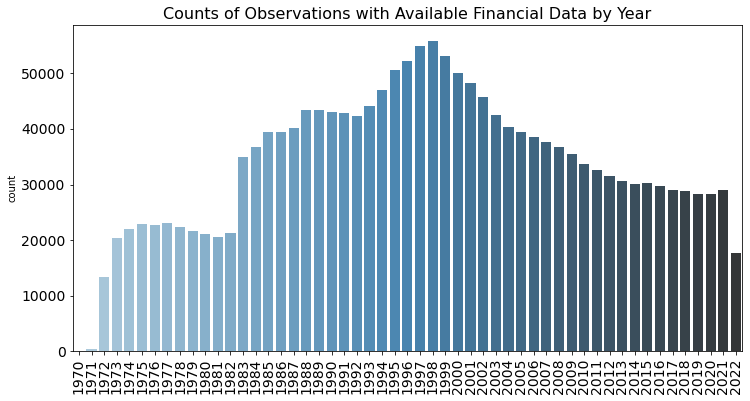

In [134]:
# plot the counts of observations by year, make pallete blues_d, its ok to have x ticks only for every 10 years
plt.figure(figsize=(12, 6))
sns.countplot(data=dropped_df, x=dropped_df['date'].dt.year, palette='Blues_d')
plt.title('Counts of Observations with Available Financial Data by Year', fontsize=16)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('', fontsize=1)

plt.show()


In [135]:
# save dropped_df as clean_financials.parquet
dropped_df.to_parquet('clean_financials.parquet', index=False)
